This notebook best viewed here: https://nbviewer.jupyter.org

This notebook is for the coastal variety of Douglas fir GEA mapping pops
* First I randomly choose one SNP per contig (only for contigs ≥ 1Kbp) with 20≤depth<1000. I tried filtering for less missing data, but this skewed MAF specta from original dataset, so I used current data at <25% missing data. 
* I then LD-prune these random SNPs to use for structure correction in baypass. I used an LD threshold of r2<~0.36 (the 99.5th percentile) this allowed for sufficient loci at the end of LD pruning. Across each filtering step and after LD pruning I compare filtered/chosen loci to the original MAF spectrum to ensure representativeness.
* I use LD-pruned SNPs to estimate the covariance matrix across 5 independent runs of the core mode of baypass, and to ensure convergence I calculate the pairwise correlation of the matrices across runs (I found that these runs were highly correlated, r2 > 0.971). I took the average of these matrices for use downstream, this average matrix was highly correlated to each of the other matrices (r2 > 0.989).
* Then I create the commands and remaining files to run baypass in IS mode (eg efile) and gfile for SNPs in our data with ADP < 1000 (average depth across pools). To parallelize baypass calls, I split up the total SNPs into 1,538 small gfiles of about 1500 loci.


In [1]:
from pythonimports import *

DIR = '/data/projects/pool_seq/DF_datasets'
snpdir = op.join(DIR, 'DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC')
assert op.exists(snpdir)
baydir = makedir(op.join(snpdir, 'baypass'))
op.exists(baydir)

True

# Choose SNPs for GEA structure correction in baypass

For SNPs with MAF > 0.05 and for all pops: 20 < DP < 1000, randomly choose one snp per contig (for contigs > 1Kbp), then LD prune so no pairwise r2 > 99.5th percentile of r2

#### get the snps

In [2]:
lview,dview = get_client()

56 56


In [3]:
def get_mafdict(afs, roundto):
    # bins for p52 depth
    mafs = [round(1-float(af),roundto) if float(af) > 0.5 else round(float(af),roundto) for af in afs]
    t = table(mafs)
    mafsdict = OrderedDict()
    for k in sorted(t):
        newk = '%.10f' % k
        if not newk in mafsdict:
            mafsdict[newk] = t[k]
        else:
            mafsdict[newk] += t[k]
    retdict = OrderedDict()
    for newk,count in mafsdict.items():
        retdict[newk] = count / sum(mafsdict.values())
    print(len(retdict.keys()))

    return retdict

def subcategorybar(X, vals, width=.9):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

def make_mafdict_fig(pruned_snpdict, all_snpdict, title=None):
    fig = plt.figure(figsize=(25,5))
    X = ['%.3f' % float(key) for key in sorted(keys(pruned_snpdict))]
    Y = [pruned_snpdict[freq] for freq in sorted(keys(pruned_snpdict))]
    Z = [all_snpdict[freq] for freq in sorted(keys(all_snpdict))]
    subcategorybar(X, [Y,Z])
    plt.legend(['filtered snps', 'all snps'],fontsize=20)
    plt.ylabel('proportion of SNPs in category',size=20)
    plt.xlabel('minor allele frequency',size=20)
    plt.title(title, size=20)
    plt.show()

def get_skipto_df(f, skipto, nrows, cols=None, filter_maf=False, **kwargs):
    """Retrieve dataframe in parallel so that all rows are captured when iterating.
    
    f = filename to open
    skipto = row number to skip, read rows thereafter
    nrows = how many rows to read from f after skipto
    """
    import pandas
    
    if skipto == 0:
        df = pandas.read_table(f, nrows=nrows-1)
    else:
        df = pandas.read_table(f, skiprows=range(1, skipto), nrows=nrows)
    
    if cols is not None:
        if isinstance(cols, str):
            cols = [cols]
        df = df[cols].copy()
    
    if filter_maf is True:
        return maf_filter(df, **kwargs)
    
    return df
dview['get_skipto_df'] = get_skipto_df

def filter_depth(*args):
    """Filter min/max depth, reduce columns."""
    chunk = get_skipto_df(*args)
    dpcols = [col for col in chunk.columns if '.DP' in col]
    freqcols = [col for col in chunk.columns if '.FREQ' in col]
    cols = ['CHROM', 'locus', 'AF', 'MAF'] + dpcols + freqcols
    chunk = chunk[cols].copy()
    for col in dpcols:
        chunk = chunk[chunk[col] >= 20].copy()
        chunk = chunk[chunk[col] < 1000].copy()
    chunk.index = chunk['locus'].tolist()
    return chunk

In [4]:
snpdir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC'

In [5]:
# get linenums for each variety and each type
linenums = {}
for f in fs(snpdir, pattern='SNP', dirs=False):
    out = !wc -l $f
    linenums[f] = int(out[0].split()[0])-1
    print(op.basename(f), linenums[f])

DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt 2291591


In [6]:
# filter for depth in parallel as I read it in
f = keys(linenums)[0]
nrows = 50000
jobs = []
for skipto in range(0, linenums[f], nrows):
    jobs.append(lview.apply_async(filter_depth, *(f, skipto, nrows)))
watch_async(jobs)

47
47


In [7]:
# combine depth-filtered chunks into one df
snps = pd.concat([j.r for j in jobs])
print(snps.shape)
snps.head()

(815406, 78)


,CHROM,locus,AF,MAF,DF_p1.DP,DF_p2.DP,DF_p23.DP,DF_p24.DP,DF_p25.DP,DF_p26.DP,DF_p27.DP,DF_p28.DP,DF_p10.DP,DF_p29.DP,DF_p30.DP,DF_p31.DP,DF_p32.DP,DF_p11.DP,DF_p12.DP,DF_p50.DP,DF_p51.DP,DF_p52.DP,DF_p53.DP,DF_p13.DP,DF_p72.DP,DF_p14.DP,DF_p73.DP,DF_p74.DP,DF_p75.DP,DF_p76.DP,DF_p77.DP,DF_p78.DP,DF_p79.DP,DF_p80.DP,DF_p81.DP,DF_p15.DP,DF_p82.DP,DF_p83.DP,DF_p84.DP,DF_p16.DP,DF_p17.DP,DF_p1.FREQ,DF_p2.FREQ,DF_p23.FREQ,DF_p24.FREQ,DF_p25.FREQ,DF_p26.FREQ,DF_p27.FREQ,DF_p28.FREQ,DF_p10.FREQ,DF_p29.FREQ,DF_p30.FREQ,DF_p31.FREQ,DF_p32.FREQ,DF_p11.FREQ,DF_p12.FREQ,DF_p50.FREQ,DF_p51.FREQ,DF_p52.FREQ,DF_p53.FREQ,DF_p13.FREQ,DF_p72.FREQ,DF_p14.FREQ,DF_p73.FREQ,DF_p74.FREQ,DF_p75.FREQ,DF_p76.FREQ,DF_p77.FREQ,DF_p78.FREQ,DF_p79.FREQ,DF_p80.FREQ,DF_p81.FREQ,DF_p15.FREQ,DF_p82.FREQ,DF_p83.FREQ,DF_p84.FREQ,DF_p16.FREQ,DF_p17.FREQ
jcf7190000000004-54508,jcf7190000000004,jcf7190000000004-54508,0.079145,0.079145,65.0,32.0,44.0,65.0,67.0,51.0,52.0,37.0,51.0,70.0,56.0,45.0,49.0,61.0,66.0,58.0,54.0,65.0,50.0,57.0,76.0,49.0,54.0,33.0,65.0,67.0,68.0,69.0,56.0,75.0,58.0,42.0,71.0,71.0,27.0,67.0,28.0,4.62%,6.25%,15.91%,10.77%,NaN,0%,5.77%,5.41%,NaN,NaN,7.14%,2.22%,6.12%,4.92%,0%,17.24%,20.37%,0%,0%,1.75%,NaN,28.57%,20.37%,3.03%,15.38%,2.99%,2.94%,NaN,7.14%,2.67%,20.69%,7.14%,NaN,5.63%,3.7%,4.48%,10.71%
jcf7190000000004-54540,jcf7190000000004,jcf7190000000004-54540,0.342281,0.342281,67.0,36.0,47.0,67.0,70.0,55.0,56.0,38.0,56.0,70.0,58.0,44.0,47.0,63.0,69.0,50.0,50.0,68.0,54.0,52.0,73.0,57.0,67.0,40.0,69.0,68.0,72.0,76.0,62.0,76.0,54.0,50.0,76.0,77.0,34.0,67.0,26.0,25.37%,30.56%,NaN,35.82%,35.71%,43.64%,32.14%,23.68%,30.36%,30%,36.21%,52.27%,21.28%,34.92%,27.54%,30%,20%,48.53%,57.41%,32.69%,27.4%,29.82%,23.88%,40%,53.62%,32.35%,44.44%,34.21%,40.32%,23.68%,29.63%,30%,27.63%,44.16%,NaN,32.84%,NaN
jcf7190000000004-54587,jcf7190000000004,jcf7190000000004-54587,0.112110,0.112110,76.0,31.0,48.0,72.0,65.0,52.0,67.0,41.0,62.0,78.0,55.0,41.0,61.0,58.0,75.0,52.0,57.0,69.0,62.0,59.0,69.0,64.0,58.0,47.0,57.0,67.0,81.0,78.0,67.0,79.0,58.0,52.0,77.0,87.0,39.0,67.0,22.0,1.32%,9.68%,20.83%,9.72%,6.15%,5.77%,4.48%,4.88%,NaN,14.1%,5.45%,0%,4.92%,1.72%,0%,15.38%,42.11%,37.68%,NaN,NaN,10.14%,21.88%,20.69%,8.51%,22.81%,5.97%,13.58%,8.97%,2.99%,NaN,18.97%,1.92%,10.39%,10.34%,NaN,5.97%,NaN
jcf7190000000004-54589,jcf7190000000004,jcf7190000000004-54589,0.800313,0.199687,75.0,31.0,46.0,74.0,67.0,50.0,67.0,41.0,60.0,78.0,55.0,41.0,60.0,57.0,73.0,51.0,56.0,69.0,63.0,59.0,71.0,63.0,59.0,44.0,58.0,67.0,79.0,77.0,65.0,78.0,58.0,54.0,74.0,87.0,39.0,67.0,22.0,86.67%,83.87%,89.13%,84.93%,83.58%,84%,58.21%,85.37%,71.67%,93.59%,80%,80.49%,78.33%,85.96%,100%,84.31%,89.29%,89.86%,61.9%,77.97%,63.38%,76.19%,72.88%,86.36%,91.38%,65.67%,93.67%,80.52%,72.31%,74.36%,79.31%,72.22%,79.73%,81.61%,58.97%,76.12%,86.36%
jcf7190000000004-54643,jcf7190000000004,jcf7190000000004-54643,0.182903,0.182903,68.0,34.0,49.0,53.0,76.0,61.0,72.0,56.0,61.0,66.0,62.0,47.0,64.0,55.0,68.0,47.0,50.0,49.0,65.0,76.0,75.0,70.0,59.0,45.0,65.0,65.0,72.0,80.0,57.0,76.0,66.0,68.0,77.0,86.0,41.0,74.0,21.0,14.71%,NaN,2.04%,22.64%,28.95%,34.43%,12.5%,12.5%,11.48%,18.18%,11.29%,31.91%,6.25%,21.82%,0%,23.4%,8%,28.57%,18.46%,21.05%,25.33%,15.71%,13.56%,37.78%,1.54%,18.46%,22.22%,30%,21.05%,NaN,12.12%,19.12%,19.48%,27.91%,9.76%,20.27%,NaN


In [8]:
# how many chromosomes
luni(snps['CHROM'])

26354

#### reduce those snps on contigs > 1Kbp

In [9]:
# get contig lengths
lengths = pd.read_table('/data/database/DouglasFir_ref_genome/DF_ref_edit.fasta.length', header=None)
lengths.head()

,0,1
0,jcf7190000000000,104664
1,jcf7190000000004,713351
2,jcf7190000000008,780568
3,jcf7190000000009,80234
4,jcf7190000000010,335878


In [10]:
# get a dict of contigs and there length if length > 1000
lens = dict((contig,length) for (contig,length) in zip(lengths[0],lengths[1]) if length>1000)
len(lens.keys())

79910

In [11]:
# reduce reduced columns to only those that matter
freqcols = [col for col in snps.columns if '.FREQ' in col]
reduced = snps[snps['CHROM'].isin(list(lens.keys()))].copy()
reduced = reduced.loc[:, freqcols + ['CHROM', 'AF', 'MAF']]
reduced.shape, snps.shape

((813190, 40), (815406, 78))

In [12]:
# how many pops?
len(freqcols)

37

In [13]:
# min contig length
min(lens.values())

1001

46
46


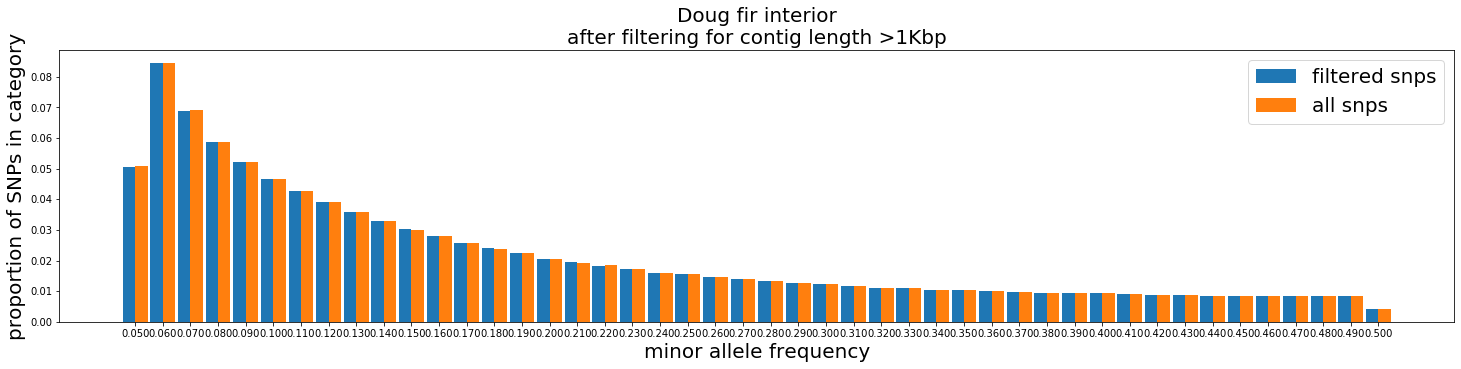

In [14]:
# compare MAF spectrum between depth-filtered and precursor
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir coastal\nafter filtering for contig length >1Kbp')

#### reduce to no missing data 

Turns out I can't filter for no missing data, the MAF spectrum doesn't match well with MAF spectrum of all data. Filter instead for % missing below.

In [15]:
def reduce_col(col):
    """Return list of loci with no missing data for pop.FREQ col."""
    return reduced[~reduced[col].isnull()].index

In [16]:
# get loci from each pop without missing data
reduce_col_outs = []
for col in nb(freqcols):
    reduce_col_outs.append(reduce_col(col))

100%|██████████| 37/37 [00:23<00:00,  1.59it/s]


In [17]:
# combine returns to get loci with no missing data across pop.FREQ cols
nomissingloci = snps.index.tolist()
for out in nb(reduce_col_outs):
    nomissingloci = list(set(nomissingloci).intersection(out))
len(nomissingloci), luni(nomissingloci)

100%|██████████| 37/37 [00:09<00:00,  4.01it/s]


(258855, 258855)

In [18]:
# reduce snp table to no missing loci
reduced_nm = reduced[reduced.index.isin(nomissingloci)]
reduced_nm.head()

,DF_p1.FREQ,DF_p2.FREQ,DF_p23.FREQ,DF_p24.FREQ,DF_p25.FREQ,DF_p26.FREQ,DF_p27.FREQ,DF_p28.FREQ,DF_p10.FREQ,DF_p29.FREQ,DF_p30.FREQ,DF_p31.FREQ,DF_p32.FREQ,DF_p11.FREQ,DF_p12.FREQ,DF_p50.FREQ,DF_p51.FREQ,DF_p52.FREQ,DF_p53.FREQ,DF_p13.FREQ,DF_p72.FREQ,DF_p14.FREQ,DF_p73.FREQ,DF_p74.FREQ,DF_p75.FREQ,DF_p76.FREQ,DF_p77.FREQ,DF_p78.FREQ,DF_p79.FREQ,DF_p80.FREQ,DF_p81.FREQ,DF_p15.FREQ,DF_p82.FREQ,DF_p83.FREQ,DF_p84.FREQ,DF_p16.FREQ,DF_p17.FREQ,CHROM,AF,MAF
jcf7190000000004-54589,86.67%,83.87%,89.13%,84.93%,83.58%,84%,58.21%,85.37%,71.67%,93.59%,80%,80.49%,78.33%,85.96%,100%,84.31%,89.29%,89.86%,61.9%,77.97%,63.38%,76.19%,72.88%,86.36%,91.38%,65.67%,93.67%,80.52%,72.31%,74.36%,79.31%,72.22%,79.73%,81.61%,58.97%,76.12%,86.36%,jcf7190000000004,0.800313,0.199687
jcf7190000000004-55528,37.08%,35%,39.68%,34.34%,35.82%,34.55%,45.45%,40.32%,34.18%,43.66%,39.33%,60.42%,46.94%,45.88%,42.55%,30.38%,31.82%,63.51%,48.19%,32.93%,45.35%,41.67%,44.29%,34.09%,58.24%,32.18%,35%,44.68%,46.59%,23.15%,21.18%,40.35%,43.86%,54.9%,25.53%,33.33%,15.38%,jcf7190000000004,0.395966,0.395966
jcf7190000000004-56179,10.48%,60.71%,35.38%,15.84%,37.5%,12.5%,29.67%,22.86%,18.52%,13.43%,22.34%,31.11%,30.95%,22.67%,12.37%,26.23%,27.5%,23.53%,13.19%,11.49%,25.27%,18.29%,15.38%,19.23%,26.83%,19.57%,22.22%,23.3%,18.8%,19.3%,14.81%,24.29%,19.42%,17.86%,19.51%,12.9%,7.69%,jcf7190000000004,0.217337,0.217337
jcf7190000000004-57381,27.27%,44%,50%,31.15%,56.25%,36.73%,35.42%,42%,39.22%,34.78%,26.15%,65.52%,53.19%,32.14%,49.09%,25.58%,35.56%,68.89%,48.15%,43.86%,55.38%,34.92%,53.19%,50%,56.06%,23.44%,41.67%,53.52%,37.68%,39.71%,29.69%,53.19%,49.23%,57.69%,25%,37.5%,29.17%,jcf7190000000004,0.425199,0.425199
jcf7190000000004-289709,32.79%,42.86%,16.67%,31.85%,27.96%,33.33%,18.48%,20.83%,31.76%,21.98%,11.57%,20%,38.67%,27.72%,30.33%,31.08%,20.9%,2.38%,10.16%,15.52%,28.24%,18%,11.46%,26.67%,12.12%,10.53%,19.88%,25.17%,35.54%,20.13%,20.41%,29.59%,19.67%,39.5%,17.5%,27.78%,30%,jcf7190000000004,0.237701,0.237701


46
46


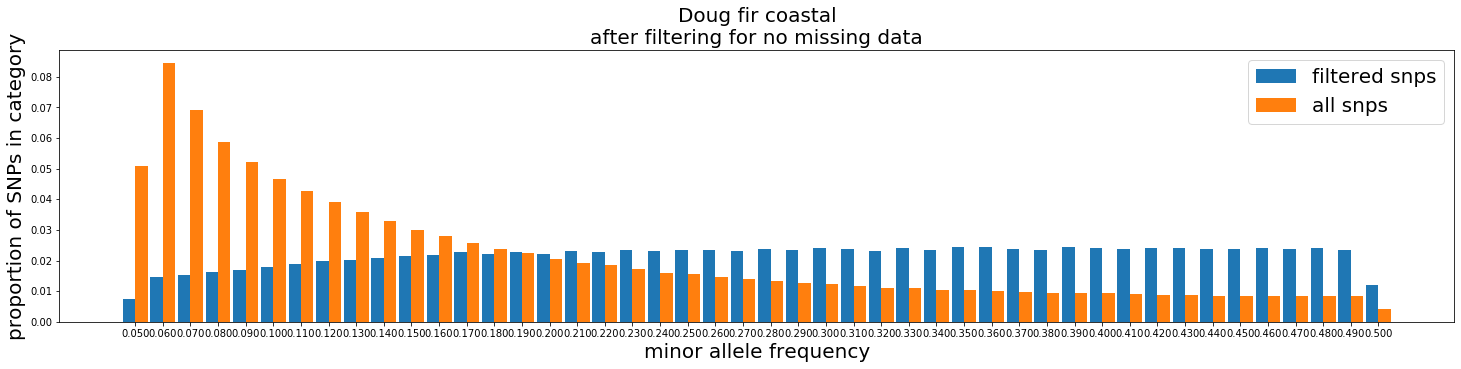

In [19]:
# compare MAF spectrum between no-missing and precursor
make_mafdict_fig(get_mafdict(reduced_nm['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir coastal\nafter filtering for no missing data')

#### try to reduce to X% missing data ... 

Result: any filtering resulted in a visibly different MAF spectrum

In [20]:
def filter_perc(df, perc=0.10):
    """Filter df for missing data below perc."""
    import pandas
    from tqdm.notebook import tqdm as tnb
    
    freqcols = [col for col in df.columns if '.FREQ' in col]
    keep = []
    for locus in tnb(df.index):
        if sum(df.loc[locus,:].isnull())/len(freqcols) <= perc:
            keep.append(locus)
    return keep

In [25]:
# see how filtering affects congruence between pre- and post-filtered data (figs below)
jobs = []
tosend = []
i = 0
for locus in tnb(reduced.index):
    tosend.append(locus)
    if len(tosend) == 21732 or (i+1)==nrow(reduced):
#         jobs.append(lview.apply_async(filter_perc, reduced.loc[tosend, :]))  # see fig below
        jobs.append(lview.apply_async(filter_perc, reduced.loc[tosend, :], **{'perc':0.2}))  # see fig below
        tosend = []
    i += 1
watch_async(jobs)

38
38


In [26]:
# gather parallel jobs
perc_loci = []
for j in jobs:
    perc_loci.extend(j.r)
len(perc_loci)

769651

46
46


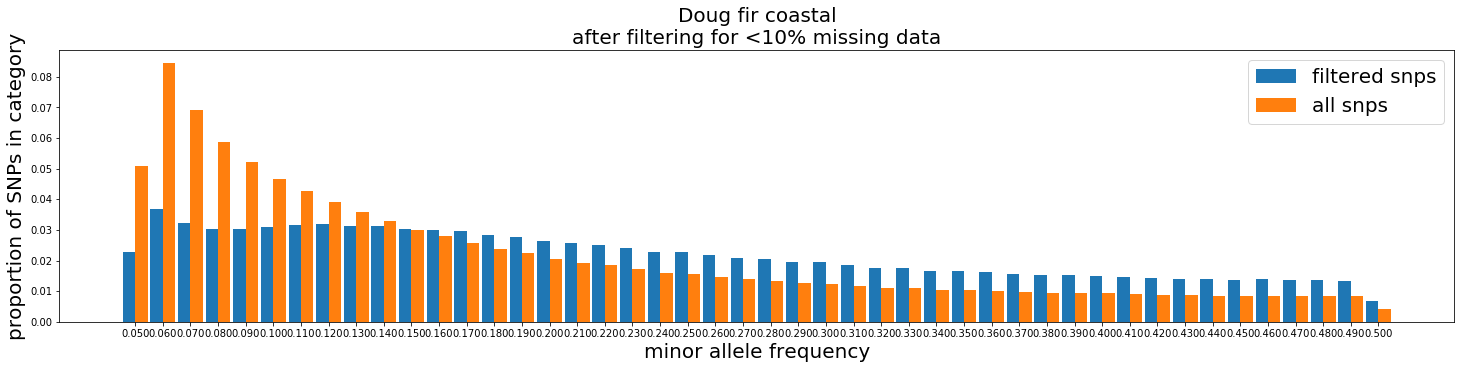

In [23]:
# compare MAF spectrum between no-missing and precursor
make_mafdict_fig(get_mafdict(reduced.loc[perc_loci, 'AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir coastal\nafter filtering for <10% missing data')

46
46


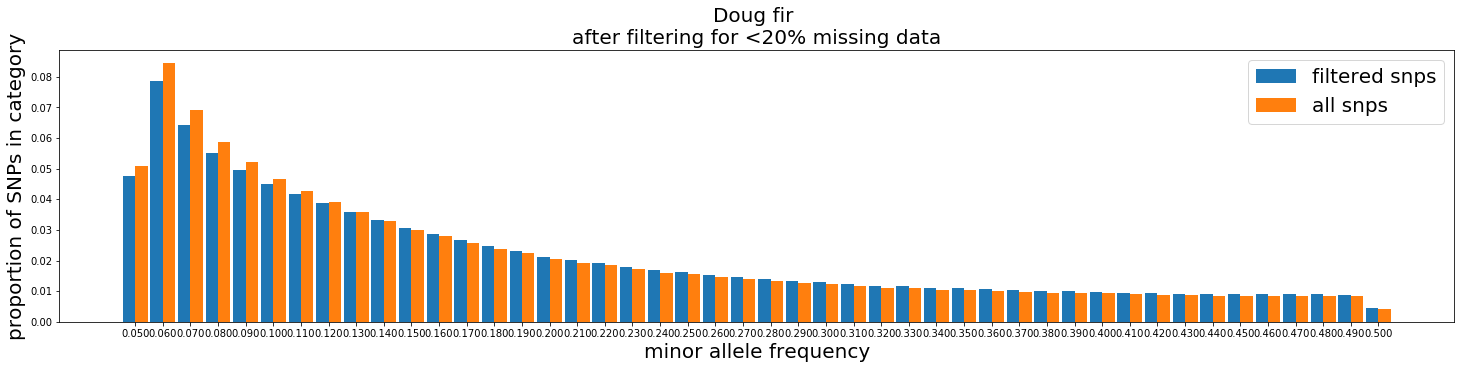

In [27]:
# compare MAF spectrum between no-missing and precursor
# MIGHT AS WELL KEEP LOCI WITHOUT FILTERING FOR MISSING DATA
make_mafdict_fig(get_mafdict(reduced.loc[perc_loci, 'AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir \nafter filtering for <20% missing data')

<center> SETTING PERC TO 0.25 MEANS NO LOCI WERE FILTERED BY MAF
    
    if I tried filtering <= 10% missing data, the MAF spectrum looked weird, leaving the code inplace. As-is (<25% missing data) will allow more contigs

#### choose one snp per contig at random

In [28]:
len(lview)

56

In [29]:
def choose_random_loci(df):
    """For each chrom in df['CHROM'], randomly choose 1 snp."""
    import pandas
    import random

    keep = []
    for chrom in uni(df['CHROM']):
        loci = df.loc[chrom, 'locus']
        if isinstance(loci, str):
            keep.append(loci)
            continue
        loci = loci.tolist()
        random.shuffle(loci)
        keep.append(loci[0])
    return keep
        
dview['uni'] = uni

In [30]:
# how many chroms do I send to a job? A: math.ceil(476.42)
luni(reduced['CHROM']), luni(reduced['CHROM'])/len(lview)

(25882, 462.17857142857144)

In [31]:
# change the index for easy sending
reduced['locus'] = reduced.index.tolist()
reduced.index = reduced['CHROM'].tolist()

In [32]:
nrow(reduced), luni(reduced['locus'])

(813190, 813190)

In [33]:
# choose random loci in parallel
jobs = []
tosend = []
i = 0
numchroms = luni(reduced['CHROM'])
for chrom in tnb(uni(reduced['CHROM'])):
    tosend.append(chrom)
    if len(tosend) == 462 or (i+1)==numchroms:
        jobs.append(lview.apply_async(choose_random_loci, reduced.loc[tosend, :]))
        tosend = []
    i += 1
watch_async(jobs)

57
57


In [34]:
# get returns from jobs
randomloci = []
for j in jobs:
    randomloci.extend(j.r)
len(randomloci) == luni(reduced['CHROM'])

True

In [35]:
# reset index, reduce reduced to only randomloci
red = reduced[reduced['locus'].isin(randomloci)].copy()
print(nrow(red), len(randomloci))
red.head()

25882 25882


,DF_p1.FREQ,DF_p2.FREQ,DF_p23.FREQ,DF_p24.FREQ,DF_p25.FREQ,DF_p26.FREQ,DF_p27.FREQ,DF_p28.FREQ,DF_p10.FREQ,DF_p29.FREQ,DF_p30.FREQ,DF_p31.FREQ,DF_p32.FREQ,DF_p11.FREQ,DF_p12.FREQ,DF_p50.FREQ,DF_p51.FREQ,DF_p52.FREQ,DF_p53.FREQ,DF_p13.FREQ,DF_p72.FREQ,DF_p14.FREQ,DF_p73.FREQ,DF_p74.FREQ,DF_p75.FREQ,DF_p76.FREQ,DF_p77.FREQ,DF_p78.FREQ,DF_p79.FREQ,DF_p80.FREQ,DF_p81.FREQ,DF_p15.FREQ,DF_p82.FREQ,DF_p83.FREQ,DF_p84.FREQ,DF_p16.FREQ,DF_p17.FREQ,CHROM,AF,MAF,locus
jcf7190000000004,42.86%,NaN,31.11%,37.1%,22.03%,46.51%,18.87%,35.85%,24.56%,37.7%,25%,NaN,14.75%,37.29%,53.7%,15%,NaN,0%,1.47%,24.62%,18.57%,15.87%,15.38%,31.25%,19.3%,20.59%,20.99%,15.38%,NaN,37.31%,21.67%,23.53%,13.04%,11.22%,40%,24.24%,NaN,jcf7190000000004,0.247835,0.247835,jcf7190000000004-57702
jcf7190000000008,10.17%,2.44%,10.94%,4.85%,11.19%,11.54%,17.12%,8.62%,7.04%,6.76%,8.05%,3.95%,NaN,10.81%,20%,7.62%,11.84%,3.37%,10.43%,7.69%,6.82%,10.48%,12.15%,9.38%,3.92%,14.07%,5.33%,9.15%,6.96%,8.11%,6.67%,15.65%,8.33%,4.79%,24.19%,10.13%,16.67%,jcf7190000000008,0.096429,0.096429,jcf7190000000008-430212
jcf7190000000011,9.15%,16.92%,8.97%,7.85%,11.9%,7.42%,8.82%,14.29%,5.81%,11.79%,14.91%,13.39%,17.76%,10.95%,20.46%,4.72%,13.56%,13.19%,12.21%,11.96%,10.7%,14.34%,14.76%,11.03%,7.4%,15.21%,13.55%,12.39%,11.86%,10.32%,17.51%,8.53%,12.96%,9.62%,11.45%,16.2%,15.56%,jcf7190000000011,0.121618,0.121618,jcf7190000000011-190565
jcf7190000000019,28.85%,NaN,36.36%,NaN,NaN,NaN,NaN,14.81%,33.33%,23.4%,32%,38.1%,NaN,25%,5.13%,33.33%,37.5%,34.09%,22.86%,31.15%,22.58%,33.33%,25%,31.58%,20%,27.27%,20.97%,22.58%,31.25%,30.19%,31.91%,34.21%,33.9%,26.25%,52%,18.33%,31.71%,jcf7190000000019,0.286489,0.286489,jcf7190000000019-15210
jcf7190000000023,1.69%,4.17%,NaN,6.25%,0%,17.78%,0%,3.77%,NaN,8.33%,NaN,6.06%,9.52%,9.09%,14.08%,NaN,4.88%,3.12%,14.29%,16.44%,12.86%,NaN,11.43%,3.03%,19.12%,NaN,12.5%,4.76%,4.76%,8.51%,5.66%,5.56%,NaN,14.46%,NaN,7.69%,4%,jcf7190000000023,0.080426,0.080426,jcf7190000000023-30169


In [36]:
# reset index
reduced = red.copy()
reduced.index = reduced['locus'].tolist()
reduced.shape

(25882, 41)

46
46


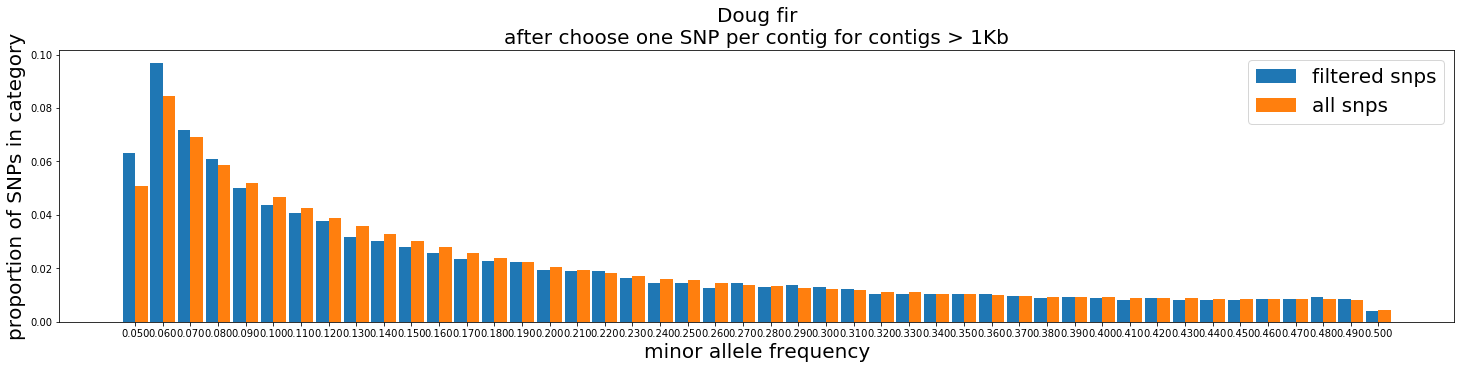

In [37]:
# compare distributions
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir\nafter choose one SNP per contig for contigs > 1Kb')

#### get an idea of r2 values so we can determine an empirical high-end cutoff

In [38]:
len(lview)

56

In [39]:
def getfreqs(myloci):
    """Get the population ALT frequency as a float (reported as a str in table).
    
    Returns
    -------
    list of tuples
        - first element = locus name
        - second element = pandas.Series
    """
    rets = []
    for locus in myloci:
        rets.append((locus, reduced.loc[locus, freqcols].str.replace("%", "").astype(float) / 100))
    return rets
dview['getfreqs'] = getfreqs
dview['freqcols'] = freqcols
dview['reduced'] = reduced[freqcols]

def getr2(myloci):
    from scipy.stats import pearsonr
    from numpy import logical_or
    from tqdm.notebook import tqdm as nb

    freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(myloci))

    r2vals = []
    i = 0
    for locusi in nb(myloci):
        for j,locusj in enumerate(myloci):
            if i < j:
                nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
                r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
                r2vals.append(r2)
        i += 1
    return r2vals

In [40]:
jobs = send_chunks(getr2, randomloci, 240, lview)
watch_async(jobs)

108
108


/data/programs/brandon_anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/programs/brandon_anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


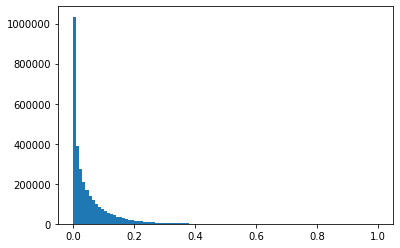

In [41]:
r2vals = []
for j in jobs:
    r2vals.extend(j.r)
plt.hist(r2vals, bins=100)
plt.show()

In [42]:
# what is 99.99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.9999)]

0.6590580236728133

In [43]:
# get 99.9th percentile
sorted(r2vals)[math.ceil(len(r2vals)*.999)]

0.485115463446523

In [44]:
# get 99.5th percentile
sorted(r2vals)[math.ceil(len(r2vals)*.995)]

0.36179385314955925

In [45]:
# what is 99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.99)]

0.30929946536470604

In [46]:
# what is 98th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.98)]

0.25600050331909613

In [47]:
# what is 97th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.97)]

0.22495857239961842

In [48]:
# what perc is 0.2
for i,x in enumerate(sorted(r2vals)):
    if x > 0.2:
        print(i)  # how many loci are below this perc?
        break
(i+1)/len(r2vals)

94103


0.030463626325281372

In [49]:
# what perc is 0.3
for i,x in enumerate(sorted(r2vals)):
    if x > 0.3:
        print(i)  # how many loci are below this perc?
        break
(i+1)/len(r2vals)

97226


0.03147461315914448

In [50]:
# what perc is 0.3606818877742702 (to compare with jack pine)
for i,x in enumerate(sorted(r2vals)):
    if x > 0.3606818877742702:
        print(i)  # how many loci are below this perc?
        break
(i+1)/len(r2vals)

97820


0.03166690460304927

In [64]:
# use 99.5th percentile
# using the 99th percentile reduce the number of loci < 4000
r2thresh = 0.36179385314955925

#### LD prune random loci¶

In [52]:
# number of loci starting out
reduced.shape

(25882, 41)

In [53]:
len(randomloci)

25882

In [54]:
snps.shape, reduced.shape

((815406, 78), (25882, 41))

In [55]:
# num pops
len(freqcols)

37

In [66]:
lview,dview = get_client()

56 56


In [67]:
# attach data to engines

# dict with key=locus, val = list of freqs for that locus
freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(randomloci))

dview['freqs'] = freqs
dview['reduced'] = None
len(freqs)

25882

In [68]:
def prune_em(compareto, locusi=None, r2thresh=0.2):
    """Prune loci by LD (r2thresh)."""
    from scipy.stats import pearsonr
    from numpy import logical_or
    
    drop = []
    for locusj in compareto:
        nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
        r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
#         print('r2 = ', r2)
        if r2 > r2thresh:
            drop.append(locusj)

    return locusi,drop

In [69]:
r2thresh

0.36179385314955925

In [70]:
# send locus along with all needed loci for pairwise comparisons to engines
# each locus (job) has r2 calculated for each of the remaining unique pairwise combinations
# so the first job compares locus1 to locus2-locusn, second job locus2 to locus3-locusn ... 
jobs = []
i = 0
for locusi in tnb(randomloci):
    tosend = randomloci[i+1:] # pairwise comparisons
    jobs.append(lview.apply_async(prune_em, tosend, **{'r2thresh':r2thresh, 'locusi':locusi}))
    i += 1

In [76]:
# iterate jobs, if finished jobs are an unbroken sequenced 0:(n-1), check returns and cancel any loci iterations
    # downstream. eg if locus0 has r2 > r2thresh with locus100, drop locus100 and kill jobs[100] to save some time

# found = {-1: None}  # comment this out after running this the first time in case I want to interrupt and restart
# keep = list(randomloci)  # comment this out after running this the first time in case I want to interrupt and restart
maxx = -1
while maxx < (len(randomloci) - 1):
    i = 0  # jcount
    for j in tnb(jobs):
        if j.ready() and i-1 in found.keys() and i not in found.keys():
            found[i] = True
            try:
                locusi, drop = j.r
            except: # CancelledError
                continue
            if locusi in keep:
                for locusj in drop:
                    if locusj in keep:
                        job_idx = randomloci.index(locusj)
    #                     print('\tcanceling ', job_idx, '. ', locusj, randomloci[job_idx])
                        jobs[job_idx].cancel()
                        keep.remove(locusj)
        i += 1
    maxx = max(found.keys())
    if maxx+1 < len(randomloci):
        update([(jobs[maxx+1].ready(), maxx, len(found.keys()), len(keep))])
        time.sleep(10)
len(keep)

(True, 25701, 25703, 4725)


4725

In [77]:
# combined varieties had 3591 ld-pruned loci
baydir = makedir(op.join(snpdir, 'baypass'))
pkl = op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3618.pkl')
pkldump(keep, pkl)

46
46


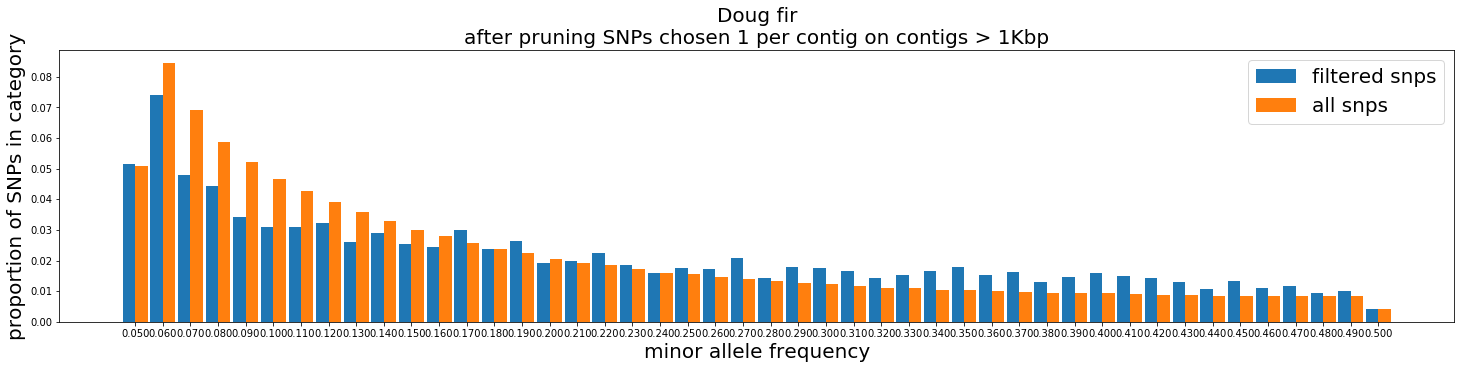

In [78]:
# compare distributions
keeping = reduced[reduced.index.isin(keep)].copy()
make_mafdict_fig(get_mafdict(keeping['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir\nafter pruning SNPs chosen 1 per contig on contigs > 1Kbp')

# create infiles to baypass to estimate neutral structure

#### <center> genotyping data

"The genotyping data file is simply organized as a matrix with
nsnp rows and 2 ∗ npop columns. The row field separator is a space. More
precisely, each row corresponds to one marker and the number of columns is
twice the number of populations because each pair of numbers corresponds to
each allele (or read counts for PoolSeq experiment) counts in one population"

In [ ]:
# RESTART NOTEBOOK! I used lower depth threshold for structure estimation

In [3]:
lview,dview = get_client()

56 56


In [5]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [8]:
# see what's in baydir
fs(baydir, bnames=True, dirs=False)

['lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3618.pkl']

In [5]:
# load LD-pruned loci
prunedloci = pklload(op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3618.pkl'))
len(prunedloci)

4725

In [10]:
# read in snps in parallel
f = keys(linenums)[0]
nrows = 50000
jobs = []
for skipto in range(0, linenums[f], nrows):
    jobs.append(lview.apply_async(get_skipto_df, *(f, skipto, nrows)))
watch_async(jobs)

47
47


In [11]:
# get pruned SNPs from read-in
snps = pd.concat([j.r for j in jobs])
snps.index = snps['locus'].tolist()
reduced = snps[snps.index.isin(prunedloci)].copy()
reduced.head()

,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p1.GT,DF_p1.GQ,DF_p1.SDP,DF_p1.DP,DF_p1.FREQ,DF_p1.PVAL,DF_p1.AD,DF_p1.RD,DF_p2.GT,DF_p2.GQ,DF_p2.SDP,DF_p2.DP,DF_p2.FREQ,DF_p2.PVAL,DF_p2.AD,DF_p2.RD,DF_p23.GT,DF_p23.GQ,DF_p23.SDP,DF_p23.DP,DF_p23.FREQ,DF_p23.PVAL,DF_p23.AD,DF_p23.RD,DF_p24.GT,DF_p24.GQ,DF_p24.SDP,DF_p24.DP,DF_p24.FREQ,DF_p24.PVAL,DF_p24.AD,DF_p24.RD,DF_p25.GT,DF_p25.GQ,DF_p25.SDP,DF_p25.DP,DF_p25.FREQ,...,DF_p15.GT,DF_p15.GQ,DF_p15.SDP,DF_p15.DP,DF_p15.FREQ,DF_p15.PVAL,DF_p15.AD,DF_p15.RD,DF_p82.GT,DF_p82.GQ,DF_p82.SDP,DF_p82.DP,DF_p82.FREQ,DF_p82.PVAL,DF_p82.AD,DF_p82.RD,DF_p83.GT,DF_p83.GQ,DF_p83.SDP,DF_p83.DP,DF_p83.FREQ,DF_p83.PVAL,DF_p83.AD,DF_p83.RD,DF_p84.GT,DF_p84.GQ,DF_p84.SDP,DF_p84.DP,DF_p84.FREQ,DF_p84.PVAL,DF_p84.AD,DF_p84.RD,DF_p16.GT,DF_p16.GQ,DF_p16.SDP,DF_p16.DP,DF_p16.FREQ,DF_p16.PVAL,DF_p16.AD,DF_p16.RD,DF_p17.GT,DF_p17.GQ,DF_p17.SDP,DF_p17.DP,DF_p17.FREQ,DF_p17.PVAL,DF_p17.AD,DF_p17.RD,locus,MAF
jcf7190000000051-473408,jcf7190000000051,473408,A,C,0.348531,-10.0,SNP,PASS,89,0,86,1,0,A/C,85.0,110,110.0,23.64%,2.789000e-09,26.0,84.0,A/C,51.0,28,28.0,50%,0.000007,14.0,14.0,A/C,53.0,61,61.0,26.23%,4.925400e-06,16.0,45.0,A/C,143.0,95,95.0,42.11%,4.802000e-15,40.0,55.0,A/C,170.0,105,105.0,44.76%,...,A/C,84.0,80,80.0,31.25%,3.216800e-09,25.0,55.0,A/C,85.0,114,114.0,22.81%,2.981000e-09,26.0,88.0,A/C,119.0,109,109.0,32.11%,1.115200e-12,35.0,74.0,A/C,40.0,38,38.0,31.58%,0.000087,12.0,26.0,A/C,160.0,126,126.0,36.51%,9.077000e-17,46.0,80.0,A/C,46.0,29,29.0,44.83%,0.000022,13.0,16.0,jcf7190000000051-473408,0.348531
jcf7190000000071-1092544,jcf7190000000071,1092544,G,A,0.075765,-10.0,SNP,PASS,118,17,70,0,0,G/A,15.0,133,133.0,NaN,3.007700e-02,5.0,128.0,G/G,25.0,26,26.0,11.54%,0.117650,3.0,23.0,G/G,173.0,108,108.0,1.85%,2.488400e-01,2.0,106.0,G/A,21.0,127,127.0,5.51%,7.176900e-03,7.0,120.0,G/A,33.0,150,150.0,7.33%,...,G/A,21.0,86,86.0,8.14%,6.881300e-03,7.0,79.0,G/A,27.0,145,145.0,6.21%,1.718600e-03,9.0,136.0,G/A,49.0,155,155.0,10.32%,1.015000e-05,16.0,139.0,G/G,68.0,58,58.0,6.9%,0.059254,4.0,54.0,G/A,33.0,165,165.0,6.67%,4.110500e-04,11.0,154.0,G/G,57.0,41,41.0,4.88%,0.246910,2.0,39.0,jcf7190000000071-1092544,0.075765
jcf7190000000084-72902,jcf7190000000084,72902,C,T,0.118247,-10.0,SNP,PASS,131,21,66,0,0,C/T,66.0,151,151.0,13.91%,2.260000e-07,21.0,130.0,C/T,29.0,42,42.0,21.43%,0.001211,9.0,33.0,C/T,57.0,104,104.0,17.31%,1.706700e-06,18.0,86.0,C/T,47.0,128,128.0,11.72%,1.975200e-05,15.0,113.0,C/T,43.0,129,129.0,10.85%,...,C/T,15.0,97,97.0,NaN,2.964400e-02,5.0,92.0,C/T,70.0,134,134.0,16.42%,9.329100e-08,22.0,112.0,C/T,46.0,168,168.0,8.93%,2.201200e-05,15.0,153.0,C/T,18.0,62,62.0,NaN,0.013767,6.0,56.0,C/T,46.0,149,149.0,10.07%,2.106800e-05,15.0,134.0,C/T,22.0,46,46.0,15.22%,0.006110,7.0,39.0,jcf7190000000084-72902,0.118247
jcf7190000000089-807159,jcf7190000000089,807159,C,T,0.318086,-10.0,SNP,PASS,40,33,53,0,1,C/T,67.0,64,64.0,31.25%,1.639700e-07,20.0,44.0,C/C,13.0,20,20.0,NaN,0.053015,4.0,16.0,C/T,65.0,29,29.0,58.62%,2.627000e-07,17.0,12.0,C/T,94.0,73,73.0,36.99%,3.854100e-10,27.0,46.0,C/T,91.0,53,53.0,47.17%,...,C/T,25.0,47,47.0,17.02%,2.824900e-03,8.0,39.0,C/T,150.0,86,86.0,47.67%,8.038000e-16,41.0,45.0,C/T,65.0,84,84.0,23.81%,2.643200e-07,20.0,64.0,C/T,33.0,30,30.0,33.33%,0.000399,10.0,20.0,C/T,64.0,60,60.0,31.67%,3.504900e-07,19.0,41.0,C/T,15.0,26,26.0,NaN,0.025310,5.0,21.0,jcf7190000000089-807159,0.318086
jcf7190000000095-25622,jcf7190000000095,25622,A,C,0.235877,-10.0,SNP,PASS,100,0,87,0,0,A/C,104.0,109,109.0,28.44%,3.856800e-11,31.0,78.0,A/C,19.0,34,34.0,NaN,0.012287,6.0,28.0,A/C,59.0,67,67.0,26.87%,1.020800e-06,18.0,49.0,A/C,68.0,97,97.0,21.65%,1.417400e-07,21.0,76.0,A/C,44.0,83,83.0,16.87%,...,A/C,99.0,85,85.0,34.12%,1.036300e-10,29.0,56.0,A/C,87.0,142,142.0,19.01%,1.901800e-09,27.0,115.0,A/C,128.0,160,160.0,24.38%,1.297300e-13,39.0,121.0,A/C,39.0,47,47.0,25.53%,0.000109,12.0,35.0,A/C,101.0,135,135.0,22.96%,6.646300e-11,31.0,104.0,A/C,19.0,31,31.0,NaN,0.011977,6.0,25.0,jcf7190000000095-2

In [12]:
# all LD-pruned loci are in full set? A: yes!
len(set(prunedloci).intersection(reduced.index)) == len(prunedloci)

True

In [13]:
# how many pops?
len([col for col in reduced.columns if '.FREQ' in col])

37

In [23]:
!pip install update tqdm

In [22]:
def get_counts(loci, numpops=0):
    """Create gfile for baypass.
    
    Get read counts for global major and minor allele. Missing data = 0."""
    import pandas
    from collections import OrderedDict
    import tqdm
    
    pops = [col.replace(".FREQ","") for col in reduced.columns if '.FREQ' in col]
    assert len(pops) == numpops
    read_counts = OrderedDict()
    for locus in tqdm.tqdm(loci):
        if reduced.loc[locus, 'AF'] > 0.5:
            # this matches calculation of MAF from 001_JP_pooled_pangenome_data_explore.ipynb
            refismajor = False
            majortag = 'AD'
            minortag = 'RD'
        else:
            refismajor = True
            majortag = 'RD'
            minortag = 'AD'
        if refismajor is True:
#             print('checking ', locus)
            # double check that it matches MAF calculation
            assert reduced.loc[locus, 'AF'] == reduced.loc[locus, 'MAF']
        for pop in pops:
            for which,tag in zip(['major','minor'],[majortag, minortag]):
                newcol = "%s-%s" % (pop,which)
                if newcol not in read_counts:
                    read_counts[newcol] = OrderedDict()
                if reduced.loc[locus, f"{pop}.FREQ"] != reduced.loc[locus, f"{pop}.FREQ"]:
                    # if locus was filtered for this pop
                    read_counts[newcol][locus] = 0
                else:
                    try:
                        read_counts[newcol][locus] = int(reduced.loc[locus, "%s.%s" % (pop, tag)])
                    except ValueError as e:
                        # missing data - probably don't need this try statement when first looking at FREQ
                        read_counts[newcol][locus] = 0
    return pandas.DataFrame(read_counts)

In [15]:
# create the neutral gfile using the prunedloci
neutral_read_counts = get_counts(prunedloci, numpops=37)
neutral_read_counts.head()

/data/programs/brandon_anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p16-major,DF_p16-minor,DF_p17-major,DF_p17-minor
jcf7190000028759-313344,52,49,21,12,38,45,54,49,60,47,57,35,79,33,49,17,69,25,51,63,42,60,57,36,56,22,60,41,78,43,41,46,46,32,25,47,44,63,43,74,40,40,44,55,44,66,25,37,65,25,61,54,78,55,67,67,57,57,58,64,54,80,34,35,53,61,35,83,41,21,48,75,20,25
jcf7190000076833-103620,83,7,0,0,77,2,80,13,97,3,72,3,82,2,66,4,83,3,89,4,81,8,62,4,71,4,82,7,109,0,71,14,39,22,67,0,93,0,94,4,0,0,58,9,67,15,69,7,83,12,0,0,96,12,96,18,90,15,90,30,83,10,64,4,0,0,116,4,28,2,103,11,28,2
jcf7190000059931-427351,107,0,22,1,101,3,98,7,96,2,62,0,121,0,107,0,96,6,186,1,109,0,98,1,81,1,75,5,65,0,89,1,93,1,29,0,38,3,100,1,63,6,105,18,118,4,67,0,97,7,55,16,123,3,88,13,86,0,153,30,100,14,47,19,142,5,118,11,63,1,103,6,88,1
jcf7190000016511-9075,71,39,0,0,39,27,49,82,46,41,38,40,42,66,49,29,29,60,33,42,55,58,23,30,37,35,58,45,44,64,48,41,48,20,62,10,95,18,51,62,57,24,44,62,70,13,25,39,59,40,67,38,41,99,72,56,61,54,88,55,70,61,27,29,75,57,47,76,15,23,66,72,23,4
jcf7190000042184-157001,56,28,16,7,32,14,57,28,46,26,43,31,50,32,54,16,74,13,34,17,65,18,39,14,34,16,49,29,28,39,52,10,45,4,62,1,88,4,69,7,60,10,64,9,61,13,26,13,48,35,89,9,73,8,70,12,65,24,106,14,65,20,49,13,0,0,83,13,22,16,77,26,22,2


In [16]:
# assert that DP = RD + AD
dpcols = [col for col in reduced.columns if '.DP' in col]
for dpcol in dpcols:
    pop = dpcol.split(".")[0]
    adcol = f"{pop}.AD"
    rdcol = f"{pop}.RD"
    assert all(reduced[dpcol] == (reduced[adcol]+reduced[rdcol]))

In [17]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [18]:
# make sure missing data makes sense
majorcols = [col for col in neutral_read_counts.columns if 'major' in col]
print(len(majorcols))  # num pops
for locus in neutral_read_counts.index:
    misscount = 0
    for col in majorcols:
        pop = col.split("-")[0]
        if neutral_read_counts.loc[locus, col] == 0 and neutral_read_counts.loc[locus, "%s-minor" % pop] == 0:
            misscount += 1
    if misscount / len(majorcols) > 0.25:
        print('crap ', locus)

37


In [19]:
# save
neutral_read_counts.to_csv(op.join(baydir, 'coastal_neutral_gfile_HEADERIDX.txt'), sep='\t', index=True)
neutral_read_counts.to_csv(op.join(baydir, 'coastal_neutral_gfile_noheaderidx.txt'), sep='\t', index=False, header=False)

#### <center> poolsizefile

"For Pool–Seq experiment, the haploid size (twice the number of pooled in- dividuals for diploid species) of each population should be provided. ... The order of the populations in the pool size file must be the same as in the allele count (and the covariate) data file(s)."

In [20]:
DIR

'/data/projects/pool_seq/DF_datasets'

In [21]:
# the reason the ploidy.keys() are not in same order of table ...
# ... is because varscan puts Sample1.X then Sample10.X ... (JP_p31 is the 10th file into varscan)
ploidy = pklload(op.join(DIR, 'DF_pooled_GEA/DF_pooled/pkl_files/ploidy.pkl'))['DF_pooled']  # get correct order
count = 0
for k,v in ploidy.items():
    print(k,v)
    count += 1
    if count == 5:
        break

DF_p1 80
DF_p10 80
DF_p11 80
DF_p12 80
DF_p13 80


In [22]:
# get ploidy of pops in same order as in gfile
pops = [col.replace("-major","") for col in neutral_read_counts.columns if '-major' in col]
vals = OrderedDict()
for pop in pops:
    vals[pop] = OrderedDict()
    vals[pop][0] = ploidy[pop]
poolsizefile = pd.DataFrame(vals)
poolsizefile

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p16,DF_p17
0,80,80,80,80,80,76,80,80,80,78,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,66,80,80,78,80,78,80,80


In [23]:
# num pops
len(poolsizefile.columns)

37

In [24]:
# compare pop order to poolsizefile
neutral_read_counts.head()

,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p16-major,DF_p16-minor,DF_p17-major,DF_p17-minor
jcf7190000028759-313344,52,49,21,12,38,45,54,49,60,47,57,35,79,33,49,17,69,25,51,63,42,60,57,36,56,22,60,41,78,43,41,46,46,32,25,47,44,63,43,74,40,40,44,55,44,66,25,37,65,25,61,54,78,55,67,67,57,57,58,64,54,80,34,35,53,61,35,83,41,21,48,75,20,25
jcf7190000076833-103620,83,7,0,0,77,2,80,13,97,3,72,3,82,2,66,4,83,3,89,4,81,8,62,4,71,4,82,7,109,0,71,14,39,22,67,0,93,0,94,4,0,0,58,9,67,15,69,7,83,12,0,0,96,12,96,18,90,15,90,30,83,10,64,4,0,0,116,4,28,2,103,11,28,2
jcf7190000059931-427351,107,0,22,1,101,3,98,7,96,2,62,0,121,0,107,0,96,6,186,1,109,0,98,1,81,1,75,5,65,0,89,1,93,1,29,0,38,3,100,1,63,6,105,18,118,4,67,0,97,7,55,16,123,3,88,13,86,0,153,30,100,14,47,19,142,5,118,11,63,1,103,6,88,1
jcf7190000016511-9075,71,39,0,0,39,27,49,82,46,41,38,40,42,66,49,29,29,60,33,42,55,58,23,30,37,35,58,45,44,64,48,41,48,20,62,10,95,18,51,62,57,24,44,62,70,13,25,39,59,40,67,38,41,99,72,56,61,54,88,55,70,61,27,29,75,57,47,76,15,23,66,72,23,4
jcf7190000042184-157001,56,28,16,7,32,14,57,28,46,26,43,31,50,32,54,16,74,13,34,17,65,18,39,14,34,16,49,29,28,39,52,10,45,4,62,1,88,4,69,7,60,10,64,9,61,13,26,13,48,35,89,9,73,8,70,12,65,24,106,14,65,20,49,13,0,0,83,13,22,16,77,26,22,2


In [25]:
# save, no need to name as 'neutral'
poolsizefile.to_csv(op.join(baydir, 'coastal_poolsizefile_HEADERIDX.txt'), sep='\t', index=False)
poolsizefile.to_csv(op.join(baydir, 'coastal_poolsizefile_noheaderidx.txt'), sep='\t', index=False, header=False)

#### <center> create random runs

In [2]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

#### make shfiles for arc server

In [5]:
# get gfile and poolsize file paths
gfile=op.join(baydir, 'coastal_neutral_gfile_noheaderidx.txt')
poolsizefile=op.join(baydir, 'coastal_poolsizefile_noheaderidx.txt')
all([op.exists(gfile), op.exists(poolsizefile)])

True

In [6]:
gfile

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/coastal_neutral_gfile_noheaderidx.txt'

In [7]:
poolsizefile

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/coastal_poolsizefile_noheaderidx.txt'

In [8]:
# create sbatch files to run baypass omega estimation

# arc paths to files (I rsynced files here to arc server)
gfile = '/home/brandon.lind/coastal_GEA_2nd_round/coastal_neutral_gfile_noheaderidx.txt'
poolsizefile = '/home/brandon.lind/coastal_GEA_2nd_round/coastal_poolsizefile_noheaderidx.txt'
shdir = makedir(op.join(baydir, 'neutral_runs/arc_shfiles'))

# create sbatch files to submit on arc server
for i in range(5):
    seed = random.randint(1,100000000)
    file = op.join(shdir, 'arc_chain_%s.sh' % str(i+1))
    cmd = f'i_baypass -gfile {gfile} -poolsizefile {poolsizefile} \
-nthreads 8 -seed {seed} -print_omega_samples -outprefix chain_{i+1} -nthreads 10'
    print(cmd,'\n')
    text = f'''#!/bin/bash
#SBATCH --job-name=chain_{i}
#SBATCH --time=12:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=10
#SBATCH --output=chain_{i}_%j.out
#SBATCH --mail-user=lindb@vcu.edu
#SBATCH --mail-type=FAIL

module load intel/2019.3

export PATH="${{PATH}}:/home/brandon.lind/src/baypass_2.2/sources"

cd /home/brandon.lind/interior_GEA_2nd_round

{cmd}


'''
    with open(file, 'w') as o:
        o.write("%s" % text)

i_baypass -gfile /home/brandon.lind/coastal_GEA_2nd_round/coastal_neutral_gfile_noheaderidx.txt -poolsizefile /home/brandon.lind/coastal_GEA_2nd_round/coastal_poolsizefile_noheaderidx.txt -nthreads 8 -seed 49291751 -print_omega_samples -outprefix chain_1 -nthreads 10 

i_baypass -gfile /home/brandon.lind/coastal_GEA_2nd_round/coastal_neutral_gfile_noheaderidx.txt -poolsizefile /home/brandon.lind/coastal_GEA_2nd_round/coastal_poolsizefile_noheaderidx.txt -nthreads 8 -seed 52262438 -print_omega_samples -outprefix chain_2 -nthreads 10 

i_baypass -gfile /home/brandon.lind/coastal_GEA_2nd_round/coastal_neutral_gfile_noheaderidx.txt -poolsizefile /home/brandon.lind/coastal_GEA_2nd_round/coastal_poolsizefile_noheaderidx.txt -nthreads 8 -seed 68784113 -print_omega_samples -outprefix chain_3 -nthreads 10 

i_baypass -gfile /home/brandon.lind/coastal_GEA_2nd_round/coastal_neutral_gfile_noheaderidx.txt -poolsizefile /home/brandon.lind/coastal_GEA_2nd_round/coastal_poolsizefile_noheaderidx.txt -n

# look at covariance matrices output from chains

In [28]:
from pythonimports import *

In [29]:
baydir = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [10]:
# get the matrix files output for each chain
ndir = op.join(baydir, 'neutral_runs')
mfiles = fs(ndir, 'mat_omega.out')
mfiles

['/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/neutral_runs/chain_1_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/neutral_runs/chain_2_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/neutral_runs/chain_3_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/neutral_runs/chain_4_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/neutral_runs/chain_5_mat_omega.out']

In [11]:
# get a list of values by vectorizing the matrix for each chain
matrices = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    text = read(m)
    rows = []
    for line in text:
        rows.extend([float(val) for val in line.split()])
    matrices[chain] = rows
len(matrices[chain])

1369

In [13]:
np.sqrt(1369)  # num pops

37.0

In [14]:
from scipy.stats import pearsonr

In [15]:
# look at pairwise correlations among chains
for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            print(chaini,chainj,pearsonr(matrices[chaini], matrices[chainj]))

chain_1 chain_2 (0.982958578167007, 0.0)
chain_1 chain_3 (0.9733057755341737, 0.0)
chain_1 chain_4 (0.9793763208922762, 0.0)
chain_1 chain_5 (0.9710170563164567, 0.0)
chain_2 chain_3 (0.9758647867223332, 0.0)
chain_2 chain_4 (0.9808021007293817, 0.0)
chain_2 chain_5 (0.9813291570969931, 0.0)
chain_3 chain_4 (0.9722831576021163, 0.0)
chain_3 chain_5 (0.979591743414875, 0.0)
chain_4 chain_5 (0.9773007978331397, 0.0)


chain_1 chain_2 0.9483277629879813 0.10005073337496231


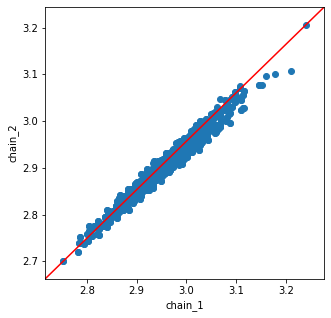

chain_1 chain_3 0.9545174686528682 0.1674621494405955


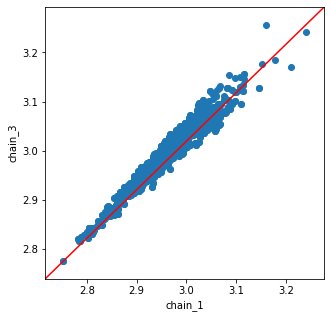

chain_1 chain_4 0.787690669954227 0.09386843079878268


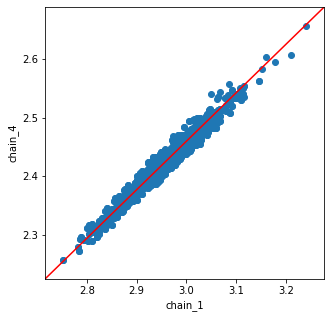

chain_1 chain_5 0.9936075096548745 0.09848343030690235


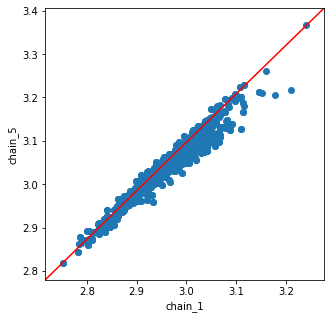

chain_2 chain_3 0.991975576608324 0.10906927784796924


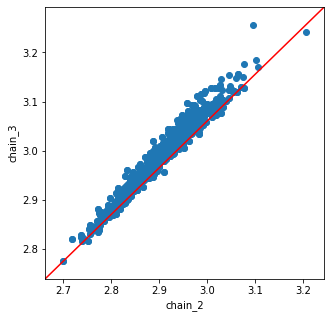

chain_2 chain_4 0.8176439756048828 0.04846686264920375


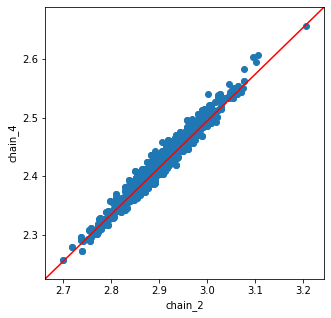

chain_2 chain_5 1.0408291851111247 0.013770238338895955


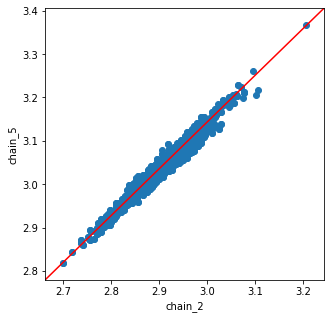

chain_3 chain_4 0.7973780643611273 0.03902916535719776


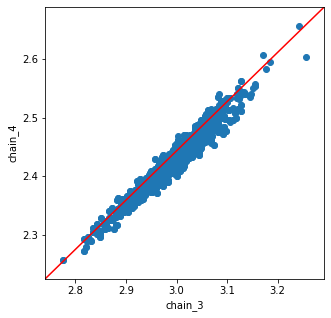

chain_3 chain_5 1.022112129864743 -0.019439019517394785


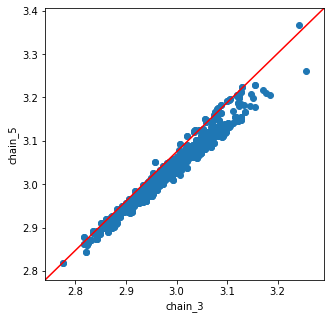

chain_4 chain_5 1.2433979820130874 0.023792161100187226


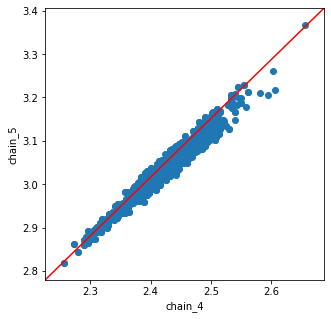

In [16]:
# plot pairwise chains agains 1:1 line, print slope and intercept from data

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            slope, intercept = np.polyfit(matrices[chaini], matrices[chainj], 1)
            print(chaini, chainj, slope, intercept)
            fig, ax = plt.subplots(figsize=(5,5))
            ax.scatter(matrices[chaini], matrices[chainj])
            ax.set_xlabel(chaini)
            ax.set_ylabel(chainj)
            line = mlines.Line2D([0, 1], [0, 1], color='red')
            transform = ax.transAxes
            line.set_transform(transform)
            ax.add_line(line)           
            
            plt.show()

In [17]:
# make a matrix with the average across matrices
mats = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    mats[chain] = pd.read_table(m, delim_whitespace=True, header=None)
mats[chain].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
0,3.101724,3.097389,3.061434,3.015745,3.023605,3.058076,3.061984,3.088054,3.081144,3.064940,3.028651,2.986777,3.062268,3.092123,2.902898,3.050516,3.033976,2.948457,2.917681,3.027833,3.074993,3.047297,3.016048,3.061235,2.961583,3.022612,3.022604,3.029583,2.989741,2.981385,3.013725,3.069907,3.000846,3.014885,3.082012,2.988876,3.147240
1,3.097389,3.261658,3.116729,3.072030,3.111096,3.118249,3.133863,3.148203,3.154822,3.145273,3.120295,3.074860,3.141626,3.155916,2.985584,3.128146,3.113176,3.025993,2.983703,3.105920,3.154011,3.120454,3.091596,3.140580,3.037333,3.095602,3.095612,3.099101,3.062915,3.048608,3.080985,3.136647,3.070542,3.086871,3.165532,3.063088,3.227986
2,3.061434,3.116729,3.134658,3.022270,3.047657,3.067636,3.097660,3.118189,3.106874,3.082007,3.045105,3.006793,3.076537,3.106009,2.935341,3.069442,3.052415,2.969147,2.940583,3.045719,3.092451,3.062264,3.027812,3.080937,2.977261,3.035573,3.037024,3.042299,3.004947,2.995574,3.029577,3.080063,3.011964,3.030417,3.097261,3.004404,3.164013
3,3.015745,3.072030,3.022270,3.034966,3.002267,3.035274,3.031495,3.053336,3.056733,3.041193,3.005565,2.969810,3.037692,3.073046,2.885970,3.030283,3.010510,2.919928,2.890635,3.007755,3.046477,3.021430,2.988950,3.037337,2.938486,2.999592,2.997157,3.003497,2.967039,2.954299,2.989761,3.041569,2.972268,2.992888,3.056146,2.965390,3.121506
4,3.023605,3.111096,3.047657,3.002267,3.088883,3.044948,3.060643,3.071409,3.082108,3.072239,3.043914,3.001592,3.063447,3.087506,2.907970,3.056966,3.039153,2.951818,2.913543,3.034903,3.080222,3.048831,3.017342,3.070261,2.960767,3.026416,3.021628,3.030997,2.995999,2.981630,3.014047,3.064580,2.998422,3.016262,3.094635,2.994738,3.150039


In [18]:
# sum across each matrix (to use in average calc below)
for chain,m in mats.items():
    print(chain)
    if chain == 'chain_1':
        summatrix = np.array(m)
    else:
        summatrix = summatrix + np.array(m)
summatrix

chain_1
chain_2
chain_3
chain_4
chain_5


array([[14.637132, 14.591646, 14.443492, ..., 14.603333, 14.114035,
        14.751707],
       [14.591646, 15.376537, 14.678848, ..., 14.981877, 14.439532,
        15.117982],
       [14.443492, 14.678848, 14.802668, ..., 14.680815, 14.184501,
        14.834413],
       ...,
       [14.603333, 14.981877, 14.680815, ..., 15.309695, 14.462382,
        15.124569],
       [14.114035, 14.439532, 14.184501, ..., 14.462382, 14.363823,
        14.665737],
       [14.751707, 15.117982, 14.834413, ..., 15.124569, 14.665737,
        15.712056]])

In [19]:
# calculate average netural matrix
avg = summatrix / len(mats)
avg.shape

(37, 37)

In [20]:
# convert to dataframe
avgmat = pd.DataFrame(avg)
print(avgmat.shape)
avgmat.head()

(37, 37)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
0,2.927426,2.918329,2.888698,2.845927,2.857628,2.880126,2.876836,2.927749,2.900336,2.894381,2.852083,2.818146,2.883408,2.917703,2.741008,2.875468,2.859792,2.783211,2.751212,2.859576,2.891945,2.874110,2.835834,2.886319,2.797765,2.852005,2.846784,2.862279,2.821705,2.805710,2.834845,2.892665,2.822273,2.851123,2.920667,2.822807,2.950341
1,2.918329,3.075307,2.935770,2.895245,2.937393,2.932785,2.941631,2.977051,2.963539,2.964802,2.936138,2.895232,2.958014,2.975079,2.811720,2.940830,2.930403,2.851177,2.810360,2.928912,2.963033,2.937390,2.900787,2.957294,2.866594,2.915191,2.909582,2.922363,2.886785,2.865771,2.893228,2.950773,2.882710,2.913872,2.996375,2.887906,3.023596
2,2.888698,2.935770,2.960534,2.853095,2.878441,2.889087,2.911372,2.957313,2.925246,2.910347,2.867625,2.835814,2.899002,2.931054,2.773766,2.892149,2.877517,2.804121,2.770121,2.874832,2.908649,2.888806,2.848200,2.906026,2.814043,2.864105,2.860552,2.876257,2.835501,2.819610,2.848502,2.901409,2.833140,2.864766,2.936163,2.836900,2.966883
3,2.845927,2.895245,2.853095,2.867185,2.836759,2.859851,2.852600,2.894659,2.877741,2.873719,2.830835,2.801243,2.862411,2.900601,2.726241,2.855050,2.839566,2.757731,2.726011,2.841242,2.867160,2.851457,2.811718,2.864502,2.776896,2.831335,2.823661,2.837866,2.800429,2.780549,2.813433,2.866913,2.797167,2.831881,2.898018,2.800430,2.926971
4,2.857628,2.937393,2.878441,2.836759,2.923160,2.872306,2.881258,2.915132,2.903660,2.905311,2.870939,2.834901,2.892210,2.916180,2.749760,2.883194,2.869424,2.788113,2.751490,2.869074,2.900798,2.879249,2.840226,2.899411,2.802515,2.857577,2.850357,2.866789,2.829809,2.809601,2.838533,2.891978,2.825324,2.856867,2.936670,2.830422,2.958384


In [21]:
# make sure avgmat is highly correlated with other chains
avgmatlst = []
for row in avgmat.index:
    for col in avgmat.columns:
        avgmatlst.append(avgmat.loc[row, col])
print(len(avgmatlst), len(matrices[chain]))

for chain,lst in matrices.items():
    print(chain, pearsonr(matrices[chain], avgmatlst))

1369 1369
chain_1 (0.9903804015728994, 0.0)
chain_2 (0.9932575663317342, 0.0)
chain_3 (0.9894733850077717, 0.0)
chain_4 (0.9902345216033193, 0.0)
chain_5 (0.9911410502125176, 0.0)


In [22]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [23]:
# save average matrix
omegafile = op.join(baydir, 'coastal_neutral_average_omegafile_noheaderidx.txt')
avgmat.to_csv(omegafile, sep='\t', index=False, header=False)

#### make sure pops are in same order as gfile

In [54]:
# load poolsize file
poolsizefile = pd.read_table(op.join(baydir, 'coastal_poolsizefile_HEADERIDX.txt'))
poolsizefile

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p16,DF_p17
0,80,80,80,80,80,76,80,80,80,78,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,66,80,80,78,80,78,80,80


In [25]:
# compare to columns on gfile
gfile = pd.read_table(op.join(baydir, 'coastal_neutral_gfile_HEADERIDX.txt'), index_col=0)
gfilecols = [list(gfile.columns)[i].split("-")[0] for i in range(0,len(gfile.columns),2)]
pd.DataFrame(columns=gfilecols)  # just so it prints pretty

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p16,DF_p17


In [26]:
# compare computationally
list(poolsizefile.columns) == gfilecols

True

In [27]:
# put columns on matrix for archiving
avgmat.columns = gfilecols
avgmat.index = gfilecols
avgmat.head()

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p16,DF_p17
DF_p1,2.927426,2.918329,2.888698,2.845927,2.857628,2.880126,2.876836,2.927749,2.900336,2.894381,2.852083,2.818146,2.883408,2.917703,2.741008,2.875468,2.859792,2.783211,2.751212,2.859576,2.891945,2.874110,2.835834,2.886319,2.797765,2.852005,2.846784,2.862279,2.821705,2.805710,2.834845,2.892665,2.822273,2.851123,2.920667,2.822807,2.950341
DF_p2,2.918329,3.075307,2.935770,2.895245,2.937393,2.932785,2.941631,2.977051,2.963539,2.964802,2.936138,2.895232,2.958014,2.975079,2.811720,2.940830,2.930403,2.851177,2.810360,2.928912,2.963033,2.937390,2.900787,2.957294,2.866594,2.915191,2.909582,2.922363,2.886785,2.865771,2.893228,2.950773,2.882710,2.913872,2.996375,2.887906,3.023596
DF_p23,2.888698,2.935770,2.960534,2.853095,2.878441,2.889087,2.911372,2.957313,2.925246,2.910347,2.867625,2.835814,2.899002,2.931054,2.773766,2.892149,2.877517,2.804121,2.770121,2.874832,2.908649,2.888806,2.848200,2.906026,2.814043,2.864105,2.860552,2.876257,2.835501,2.819610,2.848502,2.901409,2.833140,2.864766,2.936163,2.836900,2.966883
DF_p24,2.845927,2.895245,2.853095,2.867185,2.836759,2.859851,2.852600,2.894659,2.877741,2.873719,2.830835,2.801243,2.862411,2.900601,2.726241,2.855050,2.839566,2.757731,2.726011,2.841242,2.867160,2.851457,2.811718,2.864502,2.776896,2.831335,2.823661,2.837866,2.800429,2.780549,2.813433,2.866913,2.797167,2.831881,2.898018,2.800430,2.926971
DF_p25,2.857628,2.937393,2.878441,2.836759,2.923160,2.872306,2.881258,2.915132,2.903660,2.905311,2.870939,2.834901,2.892210,2.916180,2.749760,2.883194,2.869424,2.788113,2.751490,2.869074,2.900798,2.879249,2.840226,2.899411,2.802515,2.857577,2.850357,2.866789,2.829809,2.809601,2.838533,2.891978,2.825324,2.856867,2.936670,2.830422,2.958384


In [28]:
# save pop labels
avgmat.to_csv(op.join(baydir, 'interior_neutral_average_omegafile_HEADERIDX.txt'), index=True, header=True, sep='\t')

# make efile

In [30]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [31]:
poolsizefile

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p16,DF_p17
0,80,80,80,80,80,76,80,80,80,78,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,66,80,80,78,80,78,80,80


In [32]:
ncol(poolsizefile)  # num pops

37

In [33]:
# load center/standardized environmental data
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/df_coastal-naturalpops_std_env-19variables.txt')
envdata.index = envdata['our_id'].tolist()
envdata = envdata[envdata.index.isin(poolsizefile.columns)]
envdata.head()

,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p1,1,DF_p1,FDC,-126.63,49.78,225,-0.007719,-0.555477,0.516249,-0.999134,2.316004,2.577053,-1.064357,-0.798371,-0.528934,-0.343142,0.634174,-0.622818,0.395699,0.542040,0.018437,0.779604,-0.891285,-0.833964,-1.341441
DF_p2,2,DF_p2,FDC,-122.73,50.32,550,-1.102554,-0.210054,-1.849336,1.716437,-1.101435,-0.590049,0.560524,-0.102670,2.068008,-0.598228,-1.134502,0.351570,-1.411046,-0.840125,0.429618,-1.684473,-0.175201,-0.529703,0.148311
DF_p10,10,DF_p10,FDC,-125.33,50.00,152,-0.055321,-0.123699,0.021948,-0.130152,-0.558091,-0.154787,0.058288,-0.338946,-0.258852,-0.171010,0.351186,-0.574099,-0.040412,0.316381,-0.514229,0.349368,-0.325956,-0.575629,-0.428529
DF_p11,11,DF_p11,FDC,-123.97,48.95,732,-1.245358,-1.073611,-0.684197,-0.202567,0.248310,-0.154787,-0.680294,-0.432143,0.807626,-1.257719,-0.592108,0.254131,-0.538824,-0.388805,1.443553,-0.354654,-1.192793,-1.276004,-0.644217
DF_p12,12,DF_p12,FDC,-127.83,53.50,450,-1.816576,-1.203144,-2.131794,1.173322,0.121951,0.778735,-0.709838,-0.663169,2.601247,-1.407037,-1.464655,0.984922,-1.348745,-1.178614,2.401417,-1.958259,-1.418925,-1.367857,-1.005369


In [34]:
# check for 37 rows
envdata.shape

(37, 25)

In [35]:
# expecting 19 env variables
len(list(envdata.columns)[6:])

19

In [36]:
# triple check centered/standardized
for env in list(envdata.columns)[6:]:
    print(env, np.mean(envdata[env]), np.std(envdata[env]))

MAT 5.161036763122349e-16 1.0000000000000002
MWMT 6.00120553851436e-17 1.0000000000000002
MCMT -5.813667865435786e-17 1.0
TD -5.659886973511355e-16 0.9999999999999998
MAP -1.1177245315482995e-16 1.0
MSP -1.350271246165731e-17 1.0
AHM 2.355473173866886e-16 0.9999999999999998
SHM -1.2152441215491577e-16 1.0
DD_0 -6.301265815440077e-17 1.0
DD5 1.6953405646303065e-16 0.9999999999999998
NFFD 2.8055635892554633e-16 1.0
bFFP -2.550512353868603e-16 1.0
eFFP 1.8116139219390224e-16 1.0
FFP 2.08541892463374e-16 0.9999999999999999
PAS -6.901386369291513e-17 1.0
EMT -3.308164553106041e-16 1.0
EXT -1.0952200107788706e-15 1.0
Eref -2.520506326176031e-16 0.9999999999999998
CMD -5.101024707737206e-17 0.9999999999999999


In [37]:
# convert jp envdata to efile, making sure to order pops in same order as other files
efile = envdata.loc[poolsizefile.columns.tolist(), list(envdata.columns)[6:]]
efile.head()

,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p1,-0.007719,-0.555477,0.516249,-0.999134,2.316004,2.577053,-1.064357,-0.798371,-0.528934,-0.343142,0.634174,-0.622818,0.395699,0.542040,0.018437,0.779604,-0.891285,-0.833964,-1.341441
DF_p2,-1.102554,-0.210054,-1.849336,1.716437,-1.101435,-0.590049,0.560524,-0.102670,2.068008,-0.598228,-1.134502,0.351570,-1.411046,-0.840125,0.429618,-1.684473,-0.175201,-0.529703,0.148311
DF_p23,0.325491,-0.210054,0.763400,-0.962927,0.645766,0.675646,-0.635979,-0.579160,-0.708989,0.055042,1.105821,-1.256170,0.831810,1.106189,-0.565626,1.229395,-0.250578,-0.673222,-0.895017
DF_p24,-0.483734,-0.382766,-0.331125,0.014679,1.900168,1.242632,-1.034814,-0.676295,0.094332,-0.567120,-0.120461,-0.038185,-0.102713,-0.022109,1.121149,-0.061311,-0.552087,-0.759334,-1.060545
DF_p25,0.325491,0.049013,0.269098,-0.238775,0.615900,1.213996,-0.621208,-0.646104,-0.508158,0.189843,0.799250,-1.256170,0.707207,1.049774,-0.406761,0.564486,-0.212890,-0.598592,-1.150833


In [38]:
######################### VERY IMPORTANT!
# transpose df so pops are columns and env are rows
#########################
efile = efile.T
efile.head()

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p16,DF_p17
MAT,-0.007719,-1.102554,0.325491,-0.483734,0.325491,-0.055321,-1.102554,-0.578937,-0.055321,0.515897,-0.340930,0.039882,-1.340561,-1.245358,-1.816576,1.515529,1.182319,2.134349,0.373093,-1.197757,0.087484,1.325123,-1.102554,-0.959749,-1.768975,-1.483366,-0.674140,1.087116,1.610732,1.229920,0.801506,0.563499,0.468296,0.373093,0.373093,0.420694,0.563499
MWMT,-0.555477,-0.210054,-0.210054,-0.382766,0.049013,-0.123699,-1.419034,-1.116789,-0.123699,0.049013,0.783036,1.171636,-1.203144,-1.073611,-1.203144,1.948837,1.862482,2.596505,0.998925,-1.203144,0.783036,-0.037343,-0.814544,-0.814544,-0.987255,-1.159967,-0.900900,0.912569,1.085281,0.826214,-0.382766,-0.339588,-0.641833,0.049013,0.221724,0.092191,1.473881
MCMT,0.516249,-1.849336,0.763400,-0.331125,0.269098,0.198484,-0.542968,0.233791,0.021948,0.410327,-1.743414,-1.355035,-0.896041,-0.684197,-2.131794,1.081165,0.586864,1.328316,0.304406,-0.966655,-0.225203,1.787310,-0.542968,-0.684197,-1.814029,-1.072577,-0.401739,0.939936,1.540159,1.045858,1.293008,0.939936,0.975243,0.410327,0.092562,0.586864,-0.083974
TD,-0.999134,1.716437,-0.962927,0.014679,-0.238775,-0.274982,-0.600851,-1.180172,-0.130152,-0.383605,2.440589,2.368174,-0.093944,-0.202567,1.173322,0.521585,0.956077,0.847454,0.557793,-0.057736,0.883661,-1.868117,-0.130152,0.014679,1.028492,0.087094,-0.311190,-0.238775,-0.673266,-0.347397,-1.614664,-1.216380,-1.578456,-0.419813,0.123302,-0.528435,1.318153
MAP,2.316004,-1.101435,0.645766,1.900168,0.615900,0.444741,1.059305,2.018486,-0.558091,-0.556943,-1.629846,-1.542544,0.983490,0.248310,0.121951,-0.723507,-1.284082,-0.396122,-1.023323,0.872064,-1.434564,-0.389230,-0.689045,-0.381188,-0.841825,0.298853,-0.114686,-0.448963,0.994977,-0.769456,0.591777,0.998423,1.008762,-0.436327,0.218443,0.279325,-1.295569


In [39]:
# save
efile.to_csv(op.join(baydir, 'coastal_efile_std_HEADERIDX.txt'), sep='\t', index=True, header=True)
efile.to_csv(op.join(baydir, 'coastal_efile_std_noheaderidx.txt'), sep='\t', index=False, header=False)

# create gfiles for GEA from "SNP" files (ADP < 1000)

In [ ]:
# RESTART NOTEBOOK!!!

In [6]:
lview,dview = get_client()

56 56


In [7]:
linenums

{'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt': 2291591}

In [8]:
# read in snps
f = keys(linenums)[0]
snps = pd.read_table(f)
snps.index = snps['locus'].tolist()
snps.head()

,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p1.GT,DF_p1.GQ,DF_p1.SDP,DF_p1.DP,DF_p1.FREQ,DF_p1.PVAL,DF_p1.AD,DF_p1.RD,DF_p2.GT,DF_p2.GQ,DF_p2.SDP,DF_p2.DP,DF_p2.FREQ,DF_p2.PVAL,DF_p2.AD,DF_p2.RD,DF_p23.GT,DF_p23.GQ,DF_p23.SDP,DF_p23.DP,DF_p23.FREQ,DF_p23.PVAL,DF_p23.AD,DF_p23.RD,DF_p24.GT,DF_p24.GQ,DF_p24.SDP,DF_p24.DP,DF_p24.FREQ,DF_p24.PVAL,DF_p24.AD,DF_p24.RD,DF_p25.GT,DF_p25.GQ,DF_p25.SDP,DF_p25.DP,DF_p25.FREQ,...,DF_p15.GT,DF_p15.GQ,DF_p15.SDP,DF_p15.DP,DF_p15.FREQ,DF_p15.PVAL,DF_p15.AD,DF_p15.RD,DF_p82.GT,DF_p82.GQ,DF_p82.SDP,DF_p82.DP,DF_p82.FREQ,DF_p82.PVAL,DF_p82.AD,DF_p82.RD,DF_p83.GT,DF_p83.GQ,DF_p83.SDP,DF_p83.DP,DF_p83.FREQ,DF_p83.PVAL,DF_p83.AD,DF_p83.RD,DF_p84.GT,DF_p84.GQ,DF_p84.SDP,DF_p84.DP,DF_p84.FREQ,DF_p84.PVAL,DF_p84.AD,DF_p84.RD,DF_p16.GT,DF_p16.GQ,DF_p16.SDP,DF_p16.DP,DF_p16.FREQ,DF_p16.PVAL,DF_p16.AD,DF_p16.RD,DF_p17.GT,DF_p17.GQ,DF_p17.SDP,DF_p17.DP,DF_p17.FREQ,DF_p17.PVAL,DF_p17.AD,DF_p17.RD,locus,MAF
jcf7190000000000-77738,jcf7190000000000,77738,T,C,0.677466,-10.0,SNP,PASS,13,2,49,28,8,T/C,49.0,17,17.0,70.59%,0.000011,12.0,5.0,./.,NaN,6,NaN,NaN,NaN,NaN,NaN,T/C,18.0,8,8.0,NaN,0.012821,5.0,3.0,T/C,32.0,11,11.0,72.73%,5.160000e-04,8.0,3.0,T/C,29.0,15,15.0,53.33%,...,T/C,23.0,9,9.0,66.67%,0.004525,6.0,3.0,T/C,30.0,14,14.0,57.14%,9.661800e-04,8.0,6.0,C/C,91.0,24,24.0,83.33%,6.349300e-10,20.0,4.0,C/C,36.0,9,9.0,88.89%,0.000206,8.0,1.0,T/C,21.0,12,12.0,50%,6.865000e-03,6.0,6.0,T/C,32.0,11,11.0,72.73%,0.000516,8.0,3.0,jcf7190000000000-77738,0.322534
jcf7190000000000-77764,jcf7190000000000,77764,T,C,0.765881,-10.0,SNP,PASS,12,1,28,50,8,T/C,50.0,16,16.0,75%,0.000008,12.0,4.0,./.,NaN,4,NaN,NaN,NaN,NaN,NaN,./.,NaN,6,NaN,NaN,NaN,NaN,NaN,C/C,49.0,13,13.0,84.62%,1.009600e-05,11.0,2.0,T/C,34.0,15,15.0,60%,...,T/C,18.0,8,8.0,NaN,0.012821,5.0,3.0,T/C,22.0,10,10.0,60%,5.418000e-03,6.0,4.0,C/C,84.0,21,21.0,85.71%,3.760300e-09,18.0,3.0,C/C,31.0,8,8.0,87.5%,0.000699,7.0,1.0,T/C,27.0,11,11.0,63.64%,1.935000e-03,7.0,4.0,C/C,44.0,12,12.0,83.33%,0.000034,10.0,2.0,jcf7190000000000-77764,0.234119
jcf7190000000004-54418,jcf7190000000004,54418,T,C,0.355264,-10.0,SNP,PASS,36,1,86,0,0,T/C,39.0,47,47.0,25.53%,0.000109,12.0,35.0,T/C,27.0,20,20.0,40%,0.001638,8.0,12.0,T/C,26.0,31,31.0,25.81%,0.002333,8.0,23.0,T/C,32.0,43,43.0,23.26%,5.414800e-04,10.0,33.0,T/C,47.0,42,42.0,33.33%,...,T/C,44.0,38,38.0,35.14%,0.000034,13.0,25.0,T/C,74.0,53,53.0,40.38%,3.757800e-08,21.0,32.0,T/C,95.0,54,54.0,48.15%,2.717100e-10,26.0,28.0,T/C,27.0,21,21.0,38.1%,0.001724,8.0,13.0,T/C,47.0,44,44.0,31.82%,1.787300e-05,14.0,30.0,T/T,9.0,14,14.0,NaN,0.111110,3.0,11.0,jcf7190000000004-54418,0.355264
jcf7190000000004-54508,jcf7190000000004,54508,A,G,0.079145,-10.0,SNP,PASS,53,67,20,0,0,A/A,89.0,65,65.0,4.62%,0.122090,3.0,62.0,A/A,40.0,32,32.0,6.25%,0.246030,2.0,30.0,A/G,22.0,44,44.0,15.91%,0.006036,7.0,37.0,A/G,21.0,65,65.0,10.77%,6.590400e-03,7.0,58.0,A/G,15.0,67,67.0,NaN,...,A/A,49.0,42,42.0,7.14%,0.120480,3.0,39.0,A/G,15.0,71,71.0,NaN,2.905800e-02,5.0,66.0,A/A,91.0,71,71.0,5.63%,5.985000e-02,4.0,67.0,A/A,41.0,27,27.0,3.7%,0.500000,1.0,26.0,A/A,93.0,67,67.0,4.48%,1.221800e-01,3.0,64.0,A/A,28.0,28,28.0,10.71%,0.118180,3.0,25.0,jcf7190000000004-54508,0.079145
jcf7190000000004-54540,jcf7190000000004,54540,A,G,0.342281,-10.0,SNP,PASS,56,1,58,28,0,A/G,56.0,67,67.0,25.37%,0.000002,17.0,50.0,A/G,37.0,36,36.0,30.56%,0.000199,11.0,25.0,A/G,18.0,47,47.0,NaN,0.013188,6.0,41.0,A/G,83.0,67,67.0,35.82%,4.810900e-09,24.0,43.0,A/G,86.0,70,70.0,35.71%,...,A/G,50.0,50,50.0,30%,0.000009,15.0,35.0,A/G,70.0,76,76.0,27.63%,9.593900e-08,21.0,55.0,A/G,122.0,77,77.0,44.16%,5.202800e-13,34.0,43.0,A/G,19.0,34,34.0,NaN,0.012287,6.0,28.0,A/G,75.0,67,67.0,32.84%,3.020700e-08,22.0,45.0,A/G,15.0,26,26.0,NaN,0.025310,5.0,21.0,jcf7190000000004-54540,0.342281


In [ ]:
# # read in snps in parallel
# f = keys(linenums)[0]
# nrows = 10000
# jobs = []
# for skipto in range(0, linenums[f], nrows):
#     jobs.append(lview.apply_async(get_skipto_df, *(f, skipto, nrows)))
# watch_async(jobs)

In [ ]:
# # get job returns
# snps = pd.concat([j.r for j in jobs])
# snps.index = snps['locus'].tolist()
# snps.head()

In [9]:
snps.shape

(2291591, 311)

In [10]:
# reduce snps to those with ADP < 1000
reduced = snps[snps['ADP'] < 1000].copy()
reduced.shape, snps.shape

((2291485, 311), (2291591, 311))

In [11]:
# how many snps were dropped?
nrow(snps) - nrow(reduced)

106

In [11]:
# test function
x = get_counts(reduced.index[:5], 37)
x.head()

,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p16-major,DF_p16-minor,DF_p17-major,DF_p17-minor
jcf7190000000000-77738,12,5,0,0,0,0,8,3,8,7,7,3,8,7,0,0,8,7,10,12,11,7,7,6,7,4,11,1,10,2,0,0,0,0,20,3,12,2,9,7,23,1,10,4,12,1,8,9,0,0,6,10,9,6,12,2,0,0,9,9,9,4,6,3,8,6,20,4,8,1,6,6,8,3
jcf7190000000000-77764,12,4,0,0,0,0,11,2,9,6,8,1,6,7,9,0,10,5,15,7,10,4,10,4,9,3,11,1,12,1,7,4,0,0,23,0,9,0,8,6,21,2,11,3,14,1,6,7,13,3,8,7,12,4,15,1,0,0,10,3,9,4,0,0,6,4,18,3,7,1,7,4,10,2
jcf7190000000004-54418,35,12,12,8,23,8,33,10,28,14,28,13,25,11,24,15,27,10,29,14,28,11,18,15,22,20,21,19,21,21,28,10,29,7,23,17,0,0,30,12,36,18,13,14,21,12,0,0,26,10,31,11,24,13,33,24,24,18,35,15,26,13,25,13,32,21,28,26,13,8,30,14,0,0
jcf7190000000004-54508,62,3,30,2,37,7,58,7,0,0,51,0,49,3,35,2,0,0,0,0,52,4,44,1,46,3,58,3,66,0,48,10,43,11,65,0,50,0,56,1,0,0,35,14,43,11,32,1,55,10,65,2,66,2,0,0,52,4,73,2,46,12,39,3,0,0,67,4,26,1,64,3,25,3
jcf7190000000004-54540,50,17,25,11,0,0,43,24,45,25,31,24,38,18,29,9,39,17,49,21,37,21,21,23,37,10,41,22,50,19,35,15,40,10,35,33,23,31,35,17,53,20,40,17,51,16,24,16,32,37,46,22,40,32,50,26,37,25,58,18,38,16,35,15,55,21,43,34,0,0,45,22,0,0


In [12]:
# get a list of cols necessary for get_counts() to save mem on engines
important_cols = [col for col in reduced.columns if '.FREQ' in col]
important_cols.extend([col for col in reduced.columns if 'AD' in col or 'RD' in col])
important_cols.extend(['AF', 'MAF'])
len(important_cols)

114

In [17]:
# restart engines
lview,dview = get_client()

15 15


In [18]:
reduced[important_cols].shape

(2291485, 114)

In [19]:
# load reduced to engines, but only important columns
dview['reduced'] = reduced[important_cols]

In [20]:
# thresh to evenly distribute jobs
thresh = math.ceil(nrow(reduced) / len(lview))
thresh

152766

In [23]:
# send jobs to engines for get_counts() to get a gfile for all SNPs
jobs = []
tosend = []
for i,locus in enumerate(reduced.index):
    tosend.append(locus)
    if len(tosend) == thresh or (i+1)==nrow(reduced):
        jobs.append(lview.apply_async(get_counts, *(tosend, 37)))
        tosend = []
watch_async(jobs)

  0%|          | 0/15 [00:00<?, ?it/s]


Watching 15 jobs ...


100%|██████████| 15/15 [05:15<00:00, 21.06s/it]  


In [24]:
??watch_async

In [26]:
# get jobs returns
gfile = pd.concat([j.r for j in jobs])

In [27]:
# make sure returns make sense
nrow(reduced) == nrow(gfile)

True

In [28]:
# make sure returns make sense
nrow(reduced) == luni(gfile.index)

True

In [29]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [148]:
def write_file(df, filepath):
    import pandas
    if 'noheader' in filepath:
        index=False
        header=False
    else:
        index = True
        header=True
    df.to_csv(filepath, sep='\t', header=header, index=index)
    return filepath

In [34]:
# write a file for use in baypass (no header/index) and one for us to use later to label loci (header/index = True)
jobs = []
files = [op.join(baydir, 'coastal_all_snps_ADP-lt-1000_gfile_HEADERIDX.txt'),
         op.join(baydir, 'coastal_all_snps_ADP-lt-1000_gfile_noheaderidx.txt')]
for f in files:
    jobs.append(lview.apply_async(write_file, *(gfile, f)))

In [188]:
# load gfile with header/index
gfile = pd.read_table(op.join(baydir, 'coastal_all_snps_ADP-lt-1000_gfile_HEADERIDX.txt'), index_col=0)
gfile.head()

,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p16-major,DF_p16-minor,DF_p17-major,DF_p17-minor
jcf7190000000000-77738,12,5,0,0,0,0,8,3,8,7,7,3,8,7,0,0,8,7,10,12,11,7,7,6,7,4,11,1,10,2,0,0,0,0,20,3,12,2,9,7,23,1,10,4,12,1,8,9,0,0,6,10,9,6,12,2,0,0,9,9,9,4,6,3,8,6,20,4,8,1,6,6,8,3
jcf7190000000000-77764,12,4,0,0,0,0,11,2,9,6,8,1,6,7,9,0,10,5,15,7,10,4,10,4,9,3,11,1,12,1,7,4,0,0,23,0,9,0,8,6,21,2,11,3,14,1,6,7,13,3,8,7,12,4,15,1,0,0,10,3,9,4,0,0,6,4,18,3,7,1,7,4,10,2
jcf7190000000004-54418,35,12,12,8,23,8,33,10,28,14,28,13,25,11,24,15,27,10,29,14,28,11,18,15,22,20,21,19,21,21,28,10,29,7,23,17,0,0,30,12,36,18,13,14,21,12,0,0,26,10,31,11,24,13,33,24,24,18,35,15,26,13,25,13,32,21,28,26,13,8,30,14,0,0
jcf7190000000004-54508,62,3,30,2,37,7,58,7,0,0,51,0,49,3,35,2,0,0,0,0,52,4,44,1,46,3,58,3,66,0,48,10,43,11,65,0,50,0,56,1,0,0,35,14,43,11,32,1,55,10,65,2,66,2,0,0,52,4,73,2,46,12,39,3,0,0,67,4,26,1,64,3,25,3
jcf7190000000004-54540,50,17,25,11,0,0,43,24,45,25,31,24,38,18,29,9,39,17,49,21,37,21,21,23,37,10,41,22,50,19,35,15,40,10,35,33,23,31,35,17,53,20,40,17,51,16,24,16,32,37,46,22,40,32,50,26,37,25,58,18,38,16,35,15,55,21,43,34,0,0,45,22,0,0


In [35]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [36]:
# create a directory to break up main gfile into tiny gfiles for parallel baypass calls
gfile_dir = makedir(op.join(baydir, 'individual_gfiles'))

In [37]:
gfile_dir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/individual_gfiles'

In [38]:
# how many files if I split up main gfile into gfiles with 1500 SNPs each?
nrow(gfile)/1500

1537.218

In [152]:
# restart engines
lview,dview = get_client()

56 56


In [189]:
# write small gfiles to file
newjobs = []
tosend = []
jobcount = 0
for i,locus in enumerate(gfile.index):
    tosend.append(locus)
    if len(tosend) == 1500 or (i+1) == len(gfile.index):
        smallgfile = gfile.loc[tosend, :].copy()
        bname = 'coastal_all_snps_ADP-lt-1000_gfile_noheaderidx.txt'.replace('_gfile', '_gfile_%s' % str(jobcount).zfill(4))  # I changed this line
        smallpath = op.join(gfile_dir, bname)
        newjobs.append(lview.apply_async(write_file, *(smallgfile, smallpath)))
        pkldump(list(smallgfile.index), smallpath.replace(".txt", ".pkl"))  # save list of loci for later
        tosend = []
        jobcount += 1
watch_async(newjobs)

1538
1538


In [190]:
gfile_dir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/individual_gfiles'

In [191]:
# make sure there are as many baypass gfiles as there are pkl files (pkl files contain row names aka loci names)
files = fs(gfile_dir, endswith='.txt')
pkls = fs(gfile_dir, endswith='.pkl')
len(files) == len(pkls)

True

In [192]:
len(files) , len(pkls)

(1538, 1538)

In [193]:
smallgfile.head()

,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p16-major,DF_p16-minor,DF_p17-major,DF_p17-minor
jcf7190016526480-17565,32,10,0,0,0,0,48,10,29,4,25,19,35,14,0,0,28,7,34,8,42,9,29,7,28,11,32,17,34,20,34,12,26,10,31,3,24,10,54,12,38,10,35,7,0,0,28,1,23,10,33,8,56,17,47,17,25,9,48,9,0,0,21,15,40,17,45,13,0,0,48,8,13,6
jcf7190016526480-17566,41,3,0,0,34,1,48,8,31,2,32,11,44,8,0,0,34,3,39,4,49,4,34,3,36,3,36,13,45,10,43,4,27,8,33,1,31,4,0,0,46,1,0,0,33,2,28,1,33,2,0,0,64,11,55,7,32,3,0,0,30,4,25,11,44,13,51,7,18,0,48,8,0,0
jcf7190016526480-17571,24,21,0,0,20,16,24,33,16,19,33,14,32,21,18,22,24,15,26,16,24,25,31,9,21,21,30,20,26,27,33,14,0,0,12,25,15,21,45,22,29,17,29,12,20,12,19,11,24,12,29,17,38,32,24,38,18,15,33,25,22,11,24,14,39,20,31,29,0,0,30,28,0,0
jcf7190016526480-17601,32,21,6,7,29,12,43,23,28,7,33,25,40,15,32,12,30,15,28,19,44,18,23,16,30,12,28,23,41,17,25,21,20,16,39,5,31,8,47,39,23,18,26,18,28,8,17,15,30,16,38,21,53,24,56,13,21,17,47,16,20,15,26,17,31,33,38,24,15,9,46,19,9,9
jcf7190016526480-17630,42,20,0,0,28,15,51,20,31,11,30,25,36,26,35,12,38,16,33,16,42,22,24,23,26,20,34,25,40,30,33,20,18,20,32,16,26,14,59,36,27,19,32,15,25,17,26,11,37,23,29,35,56,26,46,30,25,20,42,25,26,15,26,18,43,28,42,21,10,13,43,22,12,9


In [194]:
poolsizefile

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/coastal_poolsizefile_noheaderidx.txt'

In [195]:
# triple check missing data < 25%
majorcols = [col for col in smallgfile if 'major' in col]
for locus in tnb(smallgfile.index):
    missingcount = 0
    for col in majorcols:
        if smallgfile.loc[locus, col] == 0 and smallgfile.loc[locus, col.replace("-major", "-minor")] == 0:
            missingcount += 1
    if missingcount/len(majorcols) > 0.25:
        print(locus)
        break
missingcount/len(majorcols)

0.1891891891891892

#### create new SNPs gfiles

After updating the softmasked reference there are new SNPs that were once REPEATS that need to be ran

In [30]:
# use code in previous section to get_counts() from new SNP file created after updated softmasked reference
gfile.head()  # this was recreated (some loci are different than above since it was recreated with new SNP file)

,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p16-major,DF_p16-minor,DF_p17-major,DF_p17-minor
jcf7190000000000-77738,12,5,0,0,0,0,8,3,8,7,7,3,8,7,0,0,8,7,10,12,11,7,7,6,7,4,11,1,10,2,0,0,0,0,20,3,12,2,9,7,23,1,10,4,12,1,8,9,0,0,6,10,9,6,12,2,0,0,9,9,9,4,6,3,8,6,20,4,8,1,6,6,8,3
jcf7190000000000-77764,12,4,0,0,0,0,11,2,9,6,8,1,6,7,9,0,10,5,15,7,10,4,10,4,9,3,11,1,12,1,7,4,0,0,23,0,9,0,8,6,21,2,11,3,14,1,6,7,13,3,8,7,12,4,15,1,0,0,10,3,9,4,0,0,6,4,18,3,7,1,7,4,10,2
jcf7190000000004-54418,35,12,12,8,23,8,33,10,28,14,28,13,25,11,24,15,27,10,29,14,28,11,18,15,22,20,21,19,21,21,28,10,29,7,23,17,0,0,30,12,36,18,13,14,21,12,0,0,26,10,31,11,24,13,33,24,24,18,35,15,26,13,25,13,32,21,28,26,13,8,30,14,0,0
jcf7190000000004-54508,62,3,30,2,37,7,58,7,0,0,51,0,49,3,35,2,0,0,0,0,52,4,44,1,46,3,58,3,66,0,48,10,43,11,65,0,50,0,56,1,0,0,35,14,43,11,32,1,55,10,65,2,66,2,0,0,52,4,73,2,46,12,39,3,0,0,67,4,26,1,64,3,25,3
jcf7190000000004-54540,50,17,25,11,0,0,43,24,45,25,31,24,38,18,29,9,39,17,49,21,37,21,21,23,37,10,41,22,50,19,35,15,40,10,35,33,23,31,35,17,53,20,40,17,51,16,24,16,32,37,46,22,40,32,50,26,37,25,58,18,38,16,35,15,55,21,43,34,0,0,45,22,0,0


In [31]:
# get the names of new snps (ie unique SNPS that were once REPEATS across all 03 DF datasets)
newsnps = pd.read_table('/data/projects/pool_seq/DF_datasets/previous_SNP_REPEATS/new_old/new_SNPs.txt')
newsnps.head()

,locus,CHROM,POS
0,jcf7190000023348-200565,jcf7190000023348,200565
1,jcf7190000042502-71425,jcf7190000042502,71425
2,jcf7190000113769-174435,jcf7190000113769,174435
3,jcf7190000123086-22275,jcf7190000123086,22275
4,jcf7190000042502-71598,jcf7190000042502,71598


In [32]:
# reduce to loci that aren't in current runs
newgfile = gfile[gfile.index.isin(newsnps['locus'].tolist())]
gfile.shape, newgfile.shape

((2291485, 74), (1924, 74))

In [41]:
newgfile.head()

,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p16-major,DF_p16-minor,DF_p17-major,DF_p17-minor
jcf7190000000173-53782,42,19,0,0,38,12,0,0,55,15,51,2,31,31,32,15,46,7,38,10,50,12,0,0,40,16,0,0,52,32,40,10,33,14,36,2,0,0,46,11,40,12,32,11,44,3,0,0,0,0,57,13,70,4,52,21,50,7,57,13,58,10,0,0,46,16,73,13,23,2,68,7,25,1
jcf7190000000173-53833,48,13,0,0,38,10,43,9,49,15,48,3,27,29,33,12,0,0,44,10,44,15,0,0,32,17,26,9,67,35,48,7,34,14,37,0,46,1,49,10,59,2,47,9,50,2,32,2,41,4,55,19,80,3,0,0,68,2,71,2,65,8,33,7,51,16,77,15,25,3,81,4,30,0
jcf7190000000173-53870,53,16,0,0,44,9,55,15,51,17,52,10,23,29,27,23,54,10,47,15,43,17,0,0,33,21,40,11,77,37,44,11,33,13,30,4,46,7,53,13,57,10,53,13,46,7,36,7,47,11,65,21,75,7,65,15,68,13,71,14,0,0,39,9,52,15,69,23,28,3,74,11,30,1
jcf7190000000173-53990,102,11,19,2,50,36,87,31,95,18,63,14,70,12,48,26,63,44,62,20,75,13,53,9,81,14,59,17,58,127,57,16,58,10,28,32,63,20,77,15,77,23,76,14,78,17,56,9,84,9,91,25,119,19,93,23,75,22,125,9,84,20,61,15,80,21,94,35,35,13,65,62,25,12
jcf7190000000173-54077,127,16,0,0,59,48,109,32,116,26,70,19,103,17,49,42,69,64,87,27,96,21,61,15,89,16,66,24,57,139,85,23,77,16,37,42,90,27,80,27,91,26,88,31,85,22,61,16,81,24,105,27,129,21,130,26,94,30,154,24,95,30,55,31,97,38,99,37,44,17,84,83,28,15


In [33]:
# not all newsnps are in the coastal dataset (some are in interior, or in varieties_combined)
# some of the newsnps might not have passed the ADP mark (didn't check)
nrow(newsnps)

3239

In [37]:
cmddir = op.join(baydir, 'cmd_files')
op.exists(cmddir)

True

In [42]:
# save the full table
newgfile_file = op.join(cmddir, 'coastal_all_newsnps_ADP-lt-1000_gfile_HEADERIDX.txt')
newgfile.to_csv(newgfile_file, sep='\t', index=True, header=True)

In [43]:
nrow(newgfile)

1924

In [ ]:
gfile_dir = op.join(baydir, 'individual_gfiles')

In [93]:
newgfile_file

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/coastal_all_newsnps_ADP-lt-1000_gfile_HEADERIDX.txt'

In [94]:
# split up newgfile into 8 jobs so I can run a full node on beluga or arc
# 8 gfiles * 5 chains = 40 cmds
newgfile_dir = makedir(op.join(cmddir, 'new_individual_gfiles'))
count = 0
for chunk in pd.read_table(newgfile_file, index_col=0, chunksize=math.ceil(nrow(newgfile)/8)):
    num = str(count).zfill(2)
    newfile = op.join(newgfile_dir, f'coastal_all_newsnps_ADP-lt-1000_gfile_{num}_noheaderidx.txt')
    chunk.to_csv(newfile, header=False, index=False, sep='\t')
    pkldump(chunk.index.tolist(), newfile.replace('.txt', '.pkl'))
    count += 1
newfile

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/new_individual_gfiles/coastal_all_newsnps_ADP-lt-1000_gfile_07_noheaderidx.txt'

# create commands to run baypass using gfiles from above

In [127]:
gfile_dir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/individual_gfiles'

In [196]:
# get gfiles
gfiles = fs(gfile_dir, pattern='noheader', endswith='.txt')
len(gfiles)

1538

In [63]:
# get efile
efile = op.join(baydir, 'coastal_efile_std_noheaderidx.txt')
op.exists(efile)

True

In [64]:
# get omegafile and poolsize file
omegafile = op.join(baydir, 'coastal_neutral_average_omegafile_noheaderidx.txt')
poolsizefile = op.join(baydir, 'coastal_poolsizefile_noheaderidx.txt')
op.exists(omegafile), op.exists(poolsizefile)

(True, True)

In [131]:
cmddir = makedir(op.join(baydir, 'cmd_files'))
cmddir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files'

#### as a rule of thumb, d0yij can be set to 1/5th the minimum pool size

In [132]:
# set compute canada dirs
cbay = '/scratch/lindb/coastal'
ccmddir = op.join(cbay, 'cmd_files')
cres = op.join(ccmddir, 'results')
csh = op.join(ccmddir, 'shfiles')

In [134]:
shdir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/shfiles'

In [162]:
# create baypass commands for each gfile for 5 chains each
cmds = []
for gfile in nb(gfiles):
    for chain in ['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']:
        seed = random.randint(1, 100000)
        bname = op.basename(gfile).split("_noheader")[0]
        outprefix = f"{bname}_{chain}"
        cmd = f'i_baypass -gfile {gfile.replace(baydir, cbay)} \
-efile {efile.replace(baydir, cbay)} \
-omegafile {omegafile.replace(baydir, cbay)} \
-poolsizefile {poolsizefile.replace(baydir, cbay)} \
-outprefix {outprefix} \
-d0yij 8 \
-seed {seed} \
-pilotlength 1000 \
-nval 50000 \
-npilot 40 '
        cmds.append(cmd)
len(cmds)

100%|██████████| 1538/1538 [00:00<00:00, 31417.55it/s]


7690

In [163]:
cmds[0]

'i_baypass -gfile /scratch/lindb/coastal/individual_gfiles/coastal_all_snps_ADP-lt-1000_gfile_0000_noheaderidx.txt -efile /scratch/lindb/coastal/coastal_efile_std_noheaderidx.txt -omegafile /scratch/lindb/coastal/coastal_neutral_average_omegafile_noheaderidx.txt -poolsizefile /scratch/lindb/coastal/coastal_poolsizefile_noheaderidx.txt -outprefix coastal_all_snps_ADP-lt-1000_gfile_0000_chain_1 -d0yij 8 -seed 94221 -pilotlength 1000 -nval 50000 -npilot 40 '

In [164]:
# create catfiles for baypass commands - for requests of a single node with 48 CPUs
rundir = makedir(op.join(cmddir, 'run_01'))
catfiles = []
tocat = []
for i,cmd in enumerate(nb(cmds)):
    tocat.append(cmd)
    if len(tocat) == 48 or (i+1) == len(cmds):
        file = op.join(rundir, 'catfile_%s.txt' % str(len(catfiles)).zfill(4))
        with open(file, 'w') as o:
            o.write('\n'.join(tocat))
        tocat = []
        catfiles.append(file)
len(catfiles)

100%|██████████| 7690/7690 [00:00<00:00, 378623.72it/s]


161

In [95]:
# create slurm jobs, cat catfiles at GNU parallel
resdir = makedir(op.join(cmddir, 'results'))
shdir = makedir(op.join(cmddir, 'shfiles'))
shfiles = []
for catfile in nb(catfiles):
    num = catfile.split("_")[-1].split(".")[0]
    shfile = op.join(shdir, op.basename(f"batch_{num}.sh"))
    with open(shfile, 'w') as o:
        text = f'''#!/bin/bash
#SBATCH --job-name=batch_{num}
#SBATCH --time=1-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=48
#SBATCH --output=batch_{num}_%j.out
#SBATCH --mail-user=lindb@vcu.edu
#SBATCH --mail-type=FAIL

export PATH="${{PATH}}:/project/def-saitken/programs/baypass_2.2/sources"

cd {cres}

cat {catfile.replace(cmddir, ccmddir)} | parallel -j 48 --progress

source $HOME/py3/bin/activate
cd $HOME/pipeline
python balance_queue.py lindb /home/lindb

'''
        o.write("%s" % text)
    shfiles.append(shfile)
len(shfiles)

100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


1

#### create cmds for newsnps

In [67]:
run02dir = makedir(op.join(cmddir, 'run_02'))

In [68]:
# get newgfiles
newgfiles = fs(newgfile_dir, pattern='noheader', endswith='.txt')
len(newgfiles)

8

In [84]:
# set compute canada dirs
cbay = '/scratch/lindb/coastal'
ccmddir = op.join(cbay, 'new_cmd_files')
cres = op.join(ccmddir, 'new_results')
csh = op.join(ccmddir, 'new_shfiles')
gd = op.join(ccmddir, 'new_individual_gfiles')
cd = op.join(ccmddir, 'run_02')
for d in [ccmddir, cres, csh, gd, cd]:
    print('mkdir ', d)

mkdir  /scratch/lindb/coastal/new_cmd_files
mkdir  /scratch/lindb/coastal/new_cmd_files/new_results
mkdir  /scratch/lindb/coastal/new_cmd_files/new_shfiles
mkdir  /scratch/lindb/coastal/new_cmd_files/new_individual_gfiles
mkdir  /scratch/lindb/coastal/new_cmd_files/run_02


In [88]:
# create baypass commands
cmds = []
for gfile in nb(newgfiles):
    for chain in ['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']:
        seed = random.randint(1, 100000)
        bname = op.basename(gfile).split("_noheader")[0]
        outprefix = f"{bname}_{chain}"
        cmd = f'i_baypass -gfile {gfile.replace(baydir, cbay).replace("/cmd_files/", "/new_cmd_files/")} \
-efile {efile.replace(baydir, cbay).replace("/cmd_files/", "/new_cmd_files/")} \
-omegafile {omegafile.replace(baydir, cbay).replace("/cmd_files/", "/new_cmd_files/")} \
-poolsizefile {poolsizefile.replace(baydir, cbay).replace("/cmd_files/", "/new_cmd_files/")} \
-outprefix {outprefix} \
-d0yij 8 \
-seed {seed} \
-pilotlength 1000 \
-nval 50000 \
-npilot 40 '
        cmds.append(cmd)
len(cmds)

100%|██████████| 8/8 [00:00<00:00, 12990.49it/s]


40

In [92]:
pd.read_table(gfile, header=None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,jcf7190000113769-174792,39,18,13,10,45,7,40,12,50,14,32,11,50,17,49,14,36,8,55,17,57,7,46,14,35,15,38,14,52,14,50,22,38,15,29,11,21,10,54,22,68,13,48,17,47,12,26,9,57,12,62,22,51,21,71,12,52,18,58,12,49,23,46,14,61,17,56,18,34,12,37,11,24,4
1,jcf7190000113769-174804,65,3,23,2,49,1,46,7,60,12,0,0,61,15,59,4,44,2,0,0,64,7,52,10,48,4,42,13,38,31,55,11,58,3,34,3,30,8,72,11,72,9,0,0,49,15,0,0,55,18,67,15,66,9,78,11,0,0,63,11,64,8,48,9,75,10,72,7,42,3,0,0,25,4
2,jcf7190000113769-174808,51,14,22,3,38,10,45,8,64,10,0,0,63,12,59,4,33,14,63,13,55,13,53,8,40,12,45,8,57,9,57,9,50,11,35,2,38,0,71,10,75,8,62,4,55,7,0,0,62,10,0,0,69,8,71,19,76,3,0,0,56,20,55,3,0,0,68,13,0,0,0,0,25,3
3,jcf7190000113769-174825,60,3,23,2,48,0,0,0,63,4,47,4,63,9,57,7,45,2,60,9,70,2,55,2,51,4,54,0,67,0,60,4,0,0,35,0,35,0,67,13,72,8,0,0,54,1,33,0,0,0,0,0,76,4,81,7,72,7,0,0,71,3,0,0,74,4,71,10,40,7,36,7,26,0
4,jcf7190000113769-174827,63,4,27,0,48,0,46,2,65,1,49,2,74,0,69,0,48,2,71,1,72,1,56,2,54,2,54,1,66,0,51,14,57,7,38,0,36,2,70,12,74,9,65,4,59,0,32,0,65,7,69,2,79,4,75,9,71,8,68,3,73,2,0,0,66,14,73,9,43,4,42,0,25,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,jcf7190000304914-42951,35,18,10,7,22,10,22,12,32,20,19,9,25,12,29,9,17,9,21,20,29,11,5,14,0,0,22,16,7,29,14,12,11,8,12,21,10,19,24,22,24,8,19,13,16,16,16,7,13,12,23,9,28,17,25,14,27,14,32,16,22,22,21,11,21,8,23,12,13,10,23,18,9,6
233,jcf7190016526567-47773,50,52,18,16,42,43,52,30,39,42,42,33,48,39,46,29,47,36,47,40,60,38,32,49,43,31,40,43,30,63,44,41,39,35,49,7,0,0,53,44,48,45,49,44,42,50,18,22,35,52,49,54,57,70,34,85,48,52,70,52,68,45,38,26,41,63,40,67,10,28,63,67,15,24
234,jcf7190016526567-47783,65,35,26,9,56,28,58,24,59,24,53,22,73,11,63,10,53,27,66,15,82,13,61,11,63,19,58,27,90,0,51,35,61,14,56,3,90,2,71,27,81,13,64,27,58,34,20,19,71,12,76,18,79,50,51,63,64,32,80,45,70,38,53,13,63,39,57,45,21,18,81,40,29,12
235,jcf7190016526567-47850,65,41,27,9,62,34,67,24,59,22,55,20,76,9,63,12,49,19,74,21,87,14,64,13,67,18,56,22,98,0,55,39,62,15,59,4,95,2,63,21,67,12,68,26,59,37,22,25,67,15,75,21,80,53,53,71,70,41,70,53,67,38,56,13,54,43,55,45,20,12,80,42,26,10


In [89]:
cmds[0]

'i_baypass -gfile /scratch/lindb/coastal/new_cmd_files/new_individual_gfiles/coastal_all_newsnps_ADP-lt-1000_gfile_00_noheaderidx.txt -efile /scratch/lindb/coastal/coastal_efile_std_noheaderidx.txt -omegafile /scratch/lindb/coastal/coastal_neutral_average_omegafile_noheaderidx.txt -poolsizefile /scratch/lindb/coastal/coastal_poolsizefile_noheaderidx.txt -outprefix coastal_all_newsnps_ADP-lt-1000_gfile_00_chain_1 -d0yij 8 -seed 8373 -pilotlength 1000 -nval 50000 -npilot 40 '

In [90]:
# create catfiles for baypass commands - for requests of a single node with 48 CPUs
catfiles = []
tocat = []
for i,cmd in enumerate(nb(cmds)):
    tocat.append(cmd)
    if len(tocat) == 48 or (i+1) == len(cmds):
        file = op.join(run02dir, 'catfile_%s.txt' % str(len(catfiles)).zfill(4))
        with open(file, 'w') as o:
            o.write('\n'.join(tocat))
        tocat = []
        catfiles.append(file)
len(catfiles)

100%|██████████| 40/40 [00:00<00:00, 49976.81it/s]


1

In [96]:
# use 40 CPUs to run on arc/beluga server (has good priority now)
# create slurm jobs
resdir = makedir(op.join(cmddir, 'new_results'))
shdir = makedir(op.join(cmddir, 'new_shfiles'))
shfiles = []
for catfile in nb(catfiles):
    num = catfile.split("_")[-1].split(".")[0]
    shfile = op.join(shdir, op.basename(f"batch_{num}.sh"))
    with open(shfile, 'w') as o:
        text = f'''#!/bin/bash
#SBATCH --job-name=batch_{num}
#SBATCH --time=1-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=40
#SBATCH --output=batch_{num}_%j.out
#SBATCH --mail-user=lindb@vcu.edu
#SBATCH --mail-type=FAIL

export PATH="${{PATH}}:/project/def-saitken/programs/baypass_2.2/sources"

cd {cres}

cat {catfile.replace(cmddir, ccmddir)} | parallel -j 40 --progress

source $HOME/py3/bin/activate
cd $HOME/pipeline
python balance_queue.py lindb /home/lindb

'''
        o.write("%s" % text)
    shfiles.append(shfile)
len(shfiles)

100%|██████████| 1/1 [00:00<00:00, 1332.37it/s]


1

In [ ]:
# i transferred this all by hand (scp)

# transfer to cedar, graham, beluga, and arc

In [8]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [167]:
# get infiles
files = fs(baydir, 'nohead', exclude=['all_snps', 'neutral_gfile'])
files

['/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/coastal_efile_std_noheaderidx.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/coastal_neutral_average_omegafile_noheaderidx.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/coastal_poolsizefile_noheaderidx.txt']

In [168]:
# get gfiles
gfiles = fs(gfile_dir, exclude='.pkl')
files.extend(gfiles)
len(files)

1541

In [169]:
rundir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_01'

In [170]:
shdir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/shfiles'

In [171]:
# get catfiles and shfiles
files.extend(fs(shdir, endswith='.sh'))
files.extend(fs(rundir, endswith='.txt'))
len(files)

1863

In [172]:
def exe(src, dst):
    import subprocess
    import shutil
    out = subprocess.check_output([shutil.which('rsync'), '-azv', src, dst])
    return out

In [173]:
lview,dview = get_client()

56 56


In [174]:
files[0]

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/coastal_efile_std_noheaderidx.txt'

In [175]:
cbay

'/scratch/lindb/coastal'

In [176]:
arcbay = '/home/brandon.lind/coastal_GEA_2nd_round'

In [ ]:
syncs = []
for src in files:
    dst = 'cedar:' + src.replace(baydir, cbay)
    syncs.append((src, dst))
    
    dst = 'beluga:' + src.replace(baydir, cbay)
    syncs.append((src, dst))
    
    dst = 'graham:' + src.replace(baydir, cbay)
    syncs.append((src, dst))
    
    dst = 'arc:' + src.replace(baydir, arcbay)
    syncs.append((src, dst))
dst

In [198]:
len(syncs)

6152

In [200]:
# execute system commands in parallel
jobs = make_jobs(syncs, exe, lview)
watch_async(jobs, sleep=1)

6152
6152


In [201]:
# see if any failed
needed = []
for i,j in enumerate(jobs):
    if j.ready():
        if not b'speedup' in j.r:
            needed.append(syncs[i])
len(needed)

0